# Logbook
## 24/05/22-31/05/22
### 26/05/22

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time
from numba import njit

Created Heaviside function $\chi$ but do not really know why for $x>0: y=x$.

Created the two types of regulatory functions $\psi$.

Created a method to find the values of the concentration using the Gauss-Seidel method and an explicit method.

Didn't work today, will implement the other genes tomorrow as the sum product Wg has not been implemented correctly.

In [2]:
def chi(x:float) -> int:
    """
    Heaviside function (step-function)
    
    Inputs:
        - x:float: Value to evaluate at.
    Outputs:
        - y:int: Step-function value of x.
    """
    
    if x<=0:
        y = 0
    elif x>0:
        y = 1
    else:
        print(x, 'error')
    return y

def phi_MM(x:float) -> float:
    """
    Michaelis-Menten regulatory function.
    
    Inputs:
        - x:float: Value to evaluate the function at.
    Outputs:
        - y:float: Function evaluated at x.
    """
    
    y = x/(1+x)
    return y
    
    
def sigmoid(x:float)-> float:
    """
    Sigmoid regulatory function.
    
    Inputs:
        - x:float: Value to evaluate the function at.
    Outputs:
        - y:float: Function evaluated at x.
    """
    
    y = 1/(1 + np.exp(-x))
    
    return y

def update_g_GS(genes:np.ndarray, phi:'function', Nspace:int, Ntime:int,
                ds:float, D:float, L:float, W_sum:float) -> np.ndarray:
    """
    Update NxN grid using Gauss-Seidel solver
    
    Inputs:
        - genes:np.ndarray: Previous concentration values of the genes
        - phi:'function': type of regulatory function to use
        - Nspace:int: Spatial size of the system.
        - Ntime:int: Temporal size of the system.
        - ds:float: Grid spacing and time step
        - D:float: Diffusion constant
        - L:float: Decay rate <0
        - W_sum:float: Sum of the relavent matrix elements
    Outputs:
        - genes_next:np.ndarray: Next values of the concentration of the genes
    """
    
    genes_next = np.copy(genes)
    # Avoid boundaries in update
    for i in range(1,Nspace-1):
        for n in range(1,Ntime-1):
            for c, gene in enumerate(genes):
                sumProd_Wg = np.dot(W[:,c].T, genes[:,i,n])
                genes_next[i,n] = (gene[i,n+1]/(1+L*ds) 
                          - D/ds/(1+L*ds) * (gene[i-1,n] - 2*gene[i,n] + gene[i+1,n] 
                                             + gene[i-1,n+1] -2*gene[i,n+1] + gene[i+1,n+1])
                          + chi(phi(sumProd_Wg)) + (L*ds + 1)*gene[i,n])
            
#             g_next[i,n+1] = (1/(ds/D - 2)*(g[i-1,n] -2*g[i,n] + g[i+1,n] + g[i-1,n+1] + g[i+1,n+1])
#                              + (1+L*ds)/(2*D/ds - 1)*(chi(phi(g[i,n]*W_sum)) - g[i,n])
#                             + (1+L*ds)**2/(2*D/ds - 1)*g[i,n])

                if genes_next[c,i,n] != 0:
                    print(genes_next[c,i,n])
    return genes_next


def explicit_solver(g:np.ndarray, phi:'function', Nspace:int, Ntime:int,
                dx:float, dt:float, D:float, L:float, W:np.ndarray) -> np.ndarray:
    """
    Updates time based on explicit methods.
    
    Inputs:
        - g:np.ndarray: Array to hold values of the concentration through time for all three genes
        - phi:'function': type of regulatory function to use
        - Nspace:int: Spatial size of the system.
        - Ntime:int: Temporal size of the system.
        - dx:float: Grid spacing
        - dt:float: Time step
        - D:float: Diffusion constant
        - L:float: Decay rate <0
        - W:np.ndarray: Gene interaction matrix
    Outputs:
        - g:np.ndarray: Values of the concentration though time
    """
    
    for n in range(Ntime-1):
        for i in range(1, Nspace-1):
            for c, gene in enumerate(genes):
                sumProd_Wg = np.dot(W[:,c].T, genes[:,i,n])
                genes[c, i, n+1] = (D*dt/dx**2 * (gene[i-1,n] - 2*gene[i,n] + gene[i+1,n]) 
                             + dt*chi(phi(sumProd_Wg + gene[i,n]*0.93**i)) 
                             + (L*dt + 1)*gene[i,n])
                # print(c, phi(sumProd_Wg + gene[i,n]*0.93**i), sumProd_Wg + gene[i,n]*0.93**i)
            # print('i,n,g:', i, n, g[:,i, n+1])
        
    return genes

In [3]:
W = -np.diag(np.ones(2), k=1)
W[:,0] = 1
W[2,2] = 0
W[1,:] = 0
print('W =', W)


# Number of grid points
Nspace = 50
Ntime = 500
dx = 1e-1
dt = 1e-1
D = 1e-3
L = -1.1


# Defines the threshold to stop iterating.
minChange = 1e-50
maxChange = np.inf

# Creates initial concentation
genes = np.zeros((3, Nspace, Ntime))
# Initial stripe
genes[:,Nspace//3:2*Nspace//3,0] = 1

genes = explicit_solver(genes, sigmoid, Nspace, Ntime, dx, dt, D, L, W)
print(genes)

W = [[ 1. -1. -0.]
 [ 0.  0.  0.]
 [ 1. -0.  0.]]
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.1        0.188      ... 0.83874208 0.83874208 0.83874208]
  [0.         0.1        0.189      ... 0.90364706 0.90364706 0.90364706]
  ...
  [0.         0.1        0.189      ... 0.90364706 0.90364706 0.90364706]
  [0.         0.1        0.188      ... 0.83874208 0.83874208 0.83874208]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.1        0.188      ... 0.83874208 0.83874208 0.83874208]
  [0.         0.1        0.189      ... 0.90364706 0.90364706 0.90364706]
  ...
  [0.         0.1        0.189      ... 0.90364706 0.90364706 0.90364706]
  [0.         0.1        0.188      ... 0.83874208 0.83874208 0.83874208]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.    

ValueError: x and y must have same first dimension, but have shapes (49,) and (50,)

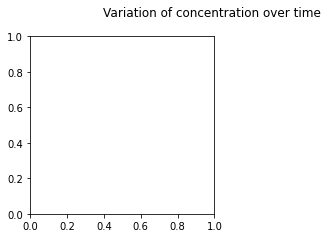

In [4]:
samplePoints = np.arange(0, dx*Nspace, dx)[:-1]

fig = plt.figure(tight_layout=True, figsize=(6,6))
fig.suptitle('Variation of concentration over time')

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    time = Ntime*(i+1)//4 - 1
    # Displays all three
    ax.plot(samplePoints, genes[0,:,time], c='r')
    ax.plot(samplePoints, genes[1,:,time], c='b')
    ax.plot(samplePoints, genes[2,:,time], c='g')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel('x')
    ax.set_ylabel('g')
    ax.set_title(f'time={time}')

plt.show(fig)

### 27/05/22
Implemented the other genes and now it somewhat works.

Needed to change $\chi$ to make the different genes exhibit different concentration profiles. Also found that the decay constant $\lambda\in[-10,-1]$.

Need to investigate the effect of changing W and understand which rows and columns correspond to which gene.

Realised there was an error in the form of the equation for the GS solver. Fixed it by redoing the algebra.

Incorporated the morphogen gradient and set the spacial region to be the number of cells. It is still unclear what the `dt` and `dx` should be.

It may be the case that I shouldn't use a new array when updating the concentrations, will investigate this further.

Found https://sites.me.ucsb.edu/~moehlis/APC591/tutorials/tutorial5/node6.html which illustrates no flux boundary conditions well.

In [ ]:
sumProd_Wg = np.dot(W[:,c].T, genes[:,i,n])
genes[c,i,n] = (gene[i,n+1]/(1+L*dt) 
          - (D[c]*dt/(2*dx**2))/(1 + L*dt) * (gene[i-1,n] - 2*gene[i,n] + gene[i+1,n] 
                             + gene[i-1,n+1] -2*gene[i,n+1] + gene[i+1,n+1])
          - chi(phi(sumProd_Wg + morphogenLeftConcentration*d**i))*dt/(L*dt+1))
# print(c,i,n,genes_next[c,i,n])

# genes_next[c,i,n+1] = (D*dt*(1+L*dt)/(2*dx**2*(1+D*dt/dx**2))*(gene[i-1,n] - 2*gene[i,n] 
#                                                              + gene[i+1,n] + gene[i-1,n+1]
#                                                              + gene[i+1,n+1])
#                     + chi(phi(sumProd_Wg + morphogenLeftConcentration*d**i)*dt/(1+D*dt/dx**2)))

Also now using `dx` and `dt` instead of only `ds` as I wanted the ability to vary the sizes independently.

Also hard coding values into them instead of having them dependent on the size of the system.



Types of mechanisms:
* Bistable
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    1 & 0 & 1 \\
    0 & -1 & 1 \\
\end{pmatrix}
$$
* Mutual inhibition
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    1 & 0 & -1 \\
    1 & -1 & 0 \\
\end{pmatrix}
$$
* Classical
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    -1 & 1 & 0 \\
    -1 & -1 & 1 \\
\end{pmatrix}
$$
* Incoherent feed-forward
$$
\begin{pmatrix}
    0 & 0 & 0 \\
    1 & 0 & 0 \\
    1 & -1 & 1 \\
\end{pmatrix}
$$
* Overlapping domains
$$
\begin{pmatrix}
    0 & 0 & -1 \\
    1 & 0 & 0 \\
    -1 & 1 & 0 \\
\end{pmatrix}
$$
* Frozen oscillator
$$
\begin{pmatrix}
    1 & -1 & -1 \\
    0 & 1 & 0 \\
    1 & -1 & 0 \\
\end{pmatrix}
$$

In [ ]:
mechanisms = np.array([[[0,0,0],[1,0,1],[0,-1,1]],
                      [[0,0,0],[1,0,-1],[1,-1,0]],
                      [[0,0,0],[-1,1,0],[-1,-1,1]],
                      [[0,0,0],[1,0,0],[-1,1,0]],
                      [[0,0,-1],[1,0,0],[-1,1,0]],
                      [[1,-1,-1],[0,1,0],[1,-1,0]]])

Now using phi_MM to get somewhat expected results but need to determine the best parameters.

In [ ]:
# No flux boundary conditions
genes[:,0,n+1] = genes[:,1,n+1]
genes[:,-1,n+1] = genes[:,-2,n+1]

## 31/05/22-07/06/22
### 31/05/22

Useful discussion with Lewis about how to determine order of magnitude estimates of the different parameters. Also discussed the steady state solution and comparing analytic and numerical solutions.

Advised by Zena to use a finite differences approach. Start with just defining the simplest system using only the simple diffusion equation.

Will do this by setting $\underline{\underline{W}} = \underline{\underline{0}}^{3,3}$.

Implemented check to see whether the parameters of the system are allowed physically:

In [ ]:
satisfactoryParameters = np.all([dt < dx**2/D for D in diffConst])
print('Parameters satisfy relation, dt*D < dx^2: ', satisfactoryParameters)

Implementing finite differences approach to the simple diffusion equation.

Found I must include a decay otherwise the values tend to infinite. Still cannot get the gradient. Will now investigate the value of M obtained from the formulation: `morphogenLeftConc*d**(i*dx))`.

Adjusting relation to include decay: $1 - \frac{D\Delta t}{(\Delta x)^2} + \lambda \Delta t > 0$.

Found an error where it seems $g[i,n,0] \approx n$.

This is probably because $\chi(\phi(M))=1 \forall M$, so just adds one onto the previous maybe.


I have successfully been able to get the morphogen gradient by removing the function $\chi(\phi())$ acting on $M$ for the above reason. Now I shall try to understand the affect of reintroducing these function. With or without decay present. 

Morphogen gradient is still present (albeit more linear) when $\phi$ is reintroduced.

I am going to attempt to build up GS simultaneously as it will be useful.

#### Discussion with Zena.
Able to create the Morphogen gradient but the parameters I am still having problems with. It is suggested that I try to remove the functions and solve the basic diffusion equation. Once I have done this I should try to fit this with an exponential and ensure that $\kappa = \sqrt{\frac{D}{\lambda}}$. I'm also going to make the coefficient $\lambda$ positive and change the equations accordingly for clarity. Also, do not need to store the state of the system at each timestep.

May alternate between two arrays so lots of copys need not be made.

In [ ]:
def finiteDifferenceSolve(concInitial:np.ndarray, Nspace:int, Nsteps:int,
                          dx:float, dt:float, diffConst:float,
                          decayConst:float, numOfSnapshots:int=10) -> np.ndarray:
    """
    Solve the diffusion equation with a finite differences approach.
    Save only 100 snapshots
    
    Inputs:
        - concInitial:np.ndarray: Initial concentration profile.
        - Nspace:int: Spatial points.
        - Nsteps:int: Number of time steps.
        - dx:float: Spatial separation.
        - dt:float: Time step.
        - diffConst: Diffusion coefficient.
        - decayConst: Degregation constant.
        - numOfSnapshots:int=10: The number of samples to take.
        
    Outputs:
        - conc:np.ndarray: The final concentration profile.
    """
    
    concHistory = np.zeros((numOfSnapshots, Nspace))
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps/numOfSnapshots)
    
    concEven = concInitial
    concOdd = np.empty(Nspace)
    
    for n in range(1, Nsteps-1):
        for i in range(1, Nspace-1):
            if n%2 == 0:
                concEven[i] = (concOdd[i]*(1 - 2*diffConst*dt/dx**2 - decayConst*dt) 
                                + diffConst*dt/dx**2 * (concOdd[i+1] + concOdd[i-1]) 
                                + morphogenLeftConc*d**(i*dx)*dt)
                # No flux boundary conditions
                concEven[0] = concEven[1]
                concEven[-1] = concEven[-2]
                
            elif n%2 == 1:
                concOdd[i] = (concEven[i]*(1 - 2*diffConst*dt/dx**2 - decayConst*dt) 
                                + diffConst*dt/dx**2 * (concEven[i+1] + concEven[i-1]) 
                                + morphogenLeftConc*d**(i*dx)*dt)
                # No flux boundary conditions
                concOdd[0] = concOdd[1]
                concOdd[-1] = concOdd[-2]

            
#             if i < Nspace/10:
#                 conc[i] += dt
            
            
            if n % snapshotPeriod == 0:
                concHistory[int(n/snapshotPeriod)] = concEven if n%2==0 else concOdd
        
            
        
        # Progress bar
        if n % int(Nsteps/10) == 0:
            print(f'Progress: {int(100*n/Nsteps)}%')
    
    return concHistory


Found that it needs to reach t=10 to stabilise.

Changing the decay constant changes the rate at which the steady state is reached. It also affects the steady-state. A larger decay constant leads to more reasonable states.

## 01/06/22
Good news, I have been able to fit the curve to an exponential with excellent accuracy by replacing the morphogen input with just `I*dx` on the left side.

Sped up computations by ~60x by using `@numba.njit`.

Changed the input morphogen in the first gene to the solution to the diffusion equation.

Need to make the gene function only take snapshots, it need not save the array at each step. Also need to have a look at the GS solver to make it compatible with todays adjustments.

In [ ]:
for i in range(1, Nspace-1):
    for n in range(Nsteps-1):
        for c, gene in enumerate(genes):
            # Explicitly writing summation instead of using dot products to allow numba to work
            sumProd_Wg = 0
            for j in range(3):
                sumProd_Wg += W[j,c]*genes[j,i,n]

            # sumProd_Wg = sum(W[:,c]*genes[:,i,n])

            genes[c,i,n+1] = (gene[i,n]*(1 - 2*diffConst[c]*dt/(dx**2) - decayConst*dt) 
                              + diffConst[c]*dt/(dx**2)*(gene[i-1,n] + gene[i+1,n]) 
                              + dt*chi(phi(sumProd_Wg + morphogenInputs[c,i])))

        # No flux boundary conditions
        genes[:,0,n+1] = genes[:,1,n+1]
        genes[:,-1,n+1] = genes[:,-2,n+1]

    # Progress bar
    if (i+2) % int(Nspace/10) == 0:
        print('Progress: ' +  str(int(100*(i+2)/Nspace)) + '%')

### 02/06/22
Implemented the snapshot mechanism and alternating arrays method. Vastly different results occur.

It turns out the Michaelis-Menten function has been written incorrectly in the supplemental.

Will analyse the referenced paper to determine the form of the functions.

In [ ]:

@njit
def phi_MM(x:float) -> float:
    """
    Michaelis-Menten regulatory function.
    
    Inputs:
        - x:float: Value to evaluate the function at.
    Outputs:
        - y:float: Function evaluated at x.
    """
    
    y = 1/(1+x)
    
    return y
    
    
def sigmoid(x:float)-> float:
    """
    Sigmoid regulatory function.
    
    Inputs:
        - x:float: Value to evaluate the function at.
    Outputs:
        - y:float: Function evaluated at x.
    """
    
    y = 1/(1 + np.exp(5-5*x))
    
    return y

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3010108/pdf/msb201074.pdf

Unlikely to use GS as the array required is far too large. Deleting:

In [ ]:
@njit
def updateGenes_GS(genes:np.ndarray, phi:'function', Ncells:int, Nsteps:int,
                dx:float, dt:float, D:tuple, L:float, W:np.ndarray) -> np.ndarray:
    """
    Update NxN grid using Gauss-Seidel solver
    
    Inputs:
        - genes:np.ndarray: Previous concentration values of the genes.
        - phi:'function': Type of regulatory function to use.
        - Ncells:int: Number of cells used.
        - Nsteps:int: Number of time steps the system is incremented.
        - dx:float: Grid spacing
        - dt:float: Time step
        - D:tuple: Diffusion coefficients
        - L:float: Decay rate <0
        - W:np.ndarray: Matrix of gene interactions
    Outputs:
        - genes_next:np.ndarray: Next values of the concentration of the genes
    """
    
    # Avoid boundaries in update
    for i in range(1,Ncells-1):
        for n in range(1,Nsteps-1):
            for c, gene in enumerate(genes):
                sumProd_Wg = np.dot(W[:,c].T, genes[:,i,n])
#                 genes[c,i,n] = (gene[i,n+1]/(1+L*dt) 
#                           - (diffConst[c]*dt/(dx**2))/(1 - decayConst*dt) * (gene[i-1,n] - 2*gene[i,n] + gene[i+1,n] 
#                                              + gene[i-1,n+1] -2*gene[i,n+1] + gene[i+1,n+1])
#                           - chi(phi(sumProd_Wg + morphogenLeftConc*d**(i*dx)))*dt/(1 - decayConst*dt))
#                 print(c,i,n,genes[c,i,n])

                
                genes[c,i,n+1] = (diffConst[c]*dt*(1-decayConst*dt)
                                  /(dx**2*(1+diffConst[c]*dt/dx**2))*(gene[i-1,n] - 2*gene[i,n] 
                                                                             + gene[i+1,n] + gene[i-1,n+1]
                                                                             + gene[i+1,n+1])
                                    + chi(phi(sumProd_Wg + morphogenLeftConc*d**(i*dx))*dt/(1+2*diffConst[c]*dt/dx**2)))

            # No flux boundary conditions
            genes[:,0,n+1] = genes[:,1,n+1]
            genes[:,-1,n+1] = genes[:,-2,n+1]
            
        # Progress bar
        if (i+2) % int(Nspace/10) == 0:
            print('Progress: ' + str(int(100*(i+2)/Nspace)) + '%')

    return genes


# Defines the threshold to stop iterating.
minChange = 1e-6
maxChange = np.inf

# Creates initial concentation
genes = 0.1*np.ones((3,Nspace,Nsteps))

# Determines potential
i = 0
maxIteration = 10
while maxChange > minChange and maxIteration != i:
    genes_prev = np.copy(genes)
    genes = updateGenes_GS(genes, phi_MM, Nspace, Nsteps, dx, dt, diffConst, decayConst, W)
    
    # Determines the max change in potential.
    maxChange = np.max(np.abs(genes - genes_prev))
    print(i, maxChange)
    i += 1
    
print(f'Iterations = {i}')
displayConcentrationProfile(genes, dx, dt, Ncells, Nsteps, Ncells)

I think I need to incorporate the noise term to find actual stable solutions.

Found that the decay rate is set to 0.05.

Note `rng` does not work with numba.

I was right about the Heaviside function being x when x>0. (Supplemental of https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3010108/pdf/msb201074.pdf)

It seems the calculated morphogen input is vastly different from the one given in the paper. I do not know why this has happened or how to resolve it.

The gene concentration profile for the red does not match the shape given in the paper too.

In [ ]:
def compareMorphogenInputs(xPoints:np.ndarray, M_calculated:np.ndarray, M_given:np.ndarray):
    """
    Compares the given and calculated morphogen concentrations.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points sampled.
        - M_calculated:np.ndarray: Calculated morphogen concentration.
        - M_given:np.ndarray: Given morphogen concentration.
    
    """
    
    # Determines the difference between calculation and given.
    difference = M_calculated - M_given
    
    fig = plt.figure(figsize=(6,6), tight_layout=True)
    fig.suptitle('Comparison of calculated and given morphogen concentration profiles')
    
    # Display both concentration profiles
    ax = fig.add_subplot(2,1,1)
    ax.plot(xPoints, M_calculated, label='calculated', c='b')
    ax.plot(xPoints, M_given, label=r'given ($Id^c$)', c='r')
    ax.grid()
    # Creates appropiate labels
    ax.legend(loc='best')
    ax.set_xlabel('x')
    ax.set_ylabel('concentration')
    
    # Display differences in concentrations
    ax = fig.add_subplot(2,1,2)
    ax.plot(xPoints, difference, c='g')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel('x')
    ax.set_ylabel('difference in concentration')
    
    plt.show(fig)

### 04/06/22
Reduce noise multiplier from $1 \pm 0.01$ to $\pm0.01$.

Trying to resolve previous issues.

### 06/06/22

Still trying to resolve previous issues.

Set $\phi_{MM} := \frac{x}{K+x}$ where K is half the morphogen's maximum value.

Set diffusion constant for all genes to zero.

Implementing a routine to automatically calculate K.

Note: also need to add a method to determine which gene the morphogen is inputted into.

Don't really know how big the spatial region should be.

Have set $K=\alpha \,\text{max}(M) \,\, ;\, \alpha \in (0,1]$

The red gene now is starting to mimic the morphogen gradient however the other two are showing identical behaviour.

Now taking an extra argument `morphogenAdjustmentQuantity` in the phi_MM function as K.

## 07/06/22-14/06/22
### 07/06/22

Discussion with Zena.

I should determine whether the model works without noise first. So temporarily remove this.

Also investigate changing all of the `phiRatio` values (three (one for each gene)).

Diffusion constants zero for all of the genes but non-zero for the morphogen.

Need to investigate the variation of the dissociation constants.

Will create a 2D grid of varying dissociation constants for two genes (probably blue and green).

In [ ]:
def analyseDissConst(genesToVary:tuple, otherRatio:float, xPoints:np.ndarray, W:np.ndarray,
                                  dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                                  diffConsts:np.ndarray, decayConst:float):
    """
    Creates a figure of the varying dissociation constants in two genes.
    
    Inputs:
        - genesToVary:tuple: Indicies of two genes to vary.
        - otherRatio:float: The phiRatio of the other gene. 
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - W:np.ndarray: The mechanism type in matrix form.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
    
    """
    
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps-2)
    
    phiRatio_rangeX = (0, 1)
    phiRatio_rangeY = (0, 1)
    
    numx = 5
    numy = 5
    
    phiRatio_x = np.linspace(phiRatio_rangeX[0], phiRatio_rangeX[1], numx)
    phiRatio_y = np.linspace(phiRatio_rangeY[0], phiRatio_rangeY[1], numy)
    
    phiRatios = np.zeros((numx, numy, 3))
    
    for i in range(numx):
        phiRatios[i,:,genesToVary[0]] = phiRatio_x
        
    for i in range(numy):
        phiRatios[:,i,genesToVary[1]] = phiRatio_y
        
    # Finds the index of the other gene
    otherGene = list({0,1,2}.difference(set(genesToVary)))
    phiRatios[:,:,otherGene[0]] = otherRatio
        
    startTime = time()
    concProfiles = np.array([[calculateGeneHistory(xPoints, W, dx, dt,
                                                   Ncells, Nspace, Nsteps,
                                  diffConsts, decayConst, 1,
                                  snapshotPeriod,
                                  phiRatio, False)[:,-1]
                              for phiRatio in phiRatioY_clump] for phiRatioY_clump in phiRatios])
    endTime = time()
    
    print(f'Calculations took {endTime - startTime} seconds')
    
    displayDissConstFigure(xPoints, phiRatio_x, phiRatio_y, numx, numy, genesToVary, concProfiles)
    
    
def displayDissConstFigure(xPoints:np.ndarray, phiRatio_x:np.ndarray, phiRatio_y:np.ndarray,
                           numx:int, numy:int, genesToVary:tuple,
                           concProfiles:np.ndarray):
    """
    Displays a figure of the concentration profiles with varying values of a dissociation constant for two genes.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - phiRatio_x:np.ndarray: x-range of phiRatios.
        - phiRatio_y:np.ndarray: y-range of phiRatios.
        - numx:int: The number of phiRatios of the first gene.
        - numy:int: The number of phiRatios of the second gene.
        - genesToVary:tuple: Indicies of the two genes to have dissociation constants vary.
        - concProfiles:np.ndarray: The concentration profiles of all genes for all dissociation constants.
    """
    
    fig = plt.figure(figsize=(numx*2, numy*2), dpi=200, tight_layout=True)
    # Creates figure labels
    fig.suptitle('Concentration profiles for various dissociation constants')
    fig.supxlabel(f'Gene {geneIndexTranslation[genesToVary[0]]}')
    fig.supylabel(f'Gene {geneIndexTranslation[genesToVary[1]]}')
    # fig.add_axes(np.ones(4))
        
    for i,px in enumerate(phiRatio_x):
        for j,py in enumerate(phiRatio_y):
            ax = fig.add_subplot(numx, numy, i*numx + j + 1)
            
            # Creates plot of all three genes
            ax.plot(xPoints, concProfiles[i,j,0], c='r')
            ax.plot(xPoints, concProfiles[i,j,1], c='b')
            ax.plot(xPoints, concProfiles[i,j,2], c='g')
            ax.grid()
            # Creates appropiate labels
            ax.set_xlabel(px)
            ax.set_ylabel(py)
            
            
    plt.show(fig)

Added a `showTime` variable so the progress is not shown when the calculation is quick and repeated alot.

Firstly, going to investigate b and g while maintaining r=0.5.

Varing both between 0 and 1 with 5 increments.

Issue occured with all of the graphs being the same, investigating error.

The issue was that I at some point replaced `phiRatio` with `phiRatios` but didn't change the parameter so it was using a global variable.

Now have a graph which visulises the data well. Need to try to converge onto a set of parameters that work.

Need to also implement a stability check so I don't need to go through all time steps. I think I will implement it with a 1% threshold for the moment. I will also need to rework the snapshot method as a result.

(b,g) = (0.25,0.5) seems to show non negligible pattern.

Will now restrict range to $b \in [0.1,0.4]$, $g \in [0.3,0.7]$

Contract to $b \in [0.4,0.7]$

There seems to be a discrepency between the graphs at (0.4,0.4). Unknown cause.

May want to clear up my axis so I know which is which.

$\lambda$ is too low as red gene needs to decay to zero. Have now changed it from 0.05 to 1.

Can find precision from https://stackoverflow.com/questions/3018758/determine-precision-and-scale-of-particular-number-in-python.

Remove xticks https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot.

Will also incorporate varying r gene dissociation constant too...maybe.

Have obtained many more interesting profiles by increasing all elements of $W$ by a factor of 5. Although the solutions are far less stable.

With the usual $W$ alot of the right threshold can be found but I cannot seem to produce the left threshold.

**Need a blue curve which is higher than the red but decreases faster.**

In [ ]:
fig = plt.figure(figsize=(numx*2, numy*1.8), dpi=300, tight_layout=True)
# Creates figure labels
fig.suptitle(f'Concentration profiles for various dissociation constants at t={dt*(Nsteps-2)}'
             + f'\nand phiRatio value of {otherRatio} for gene {geneIndexTranslation[otherGene]}')
fig.supxlabel(f'Gene {geneIndexTranslation[genesToVary[0]]} / max(M)', color='purple')
fig.supylabel(f'Gene {geneIndexTranslation[genesToVary[1]]} / max(M)', color='purple')
# fig.add_axes(np.ones(4))

for i,px in enumerate(phiRatio_x):
    for j,py in enumerate(phiRatio_y):
        ax = fig.add_subplot(numx, numy, i*numx + j + 1)

        # Creates plot of all three genes
        for c in range(3):
            ax.plot(xPoints, concProfiles[i,j,c], c=geneIndexTranslation[c], marker='.', markersize=2.5)
        ax.grid(axis='y')

        # Creates appropiate labels
        ax.set_ylim(bottom=-0.1)
        if j==0:
            ax.set_ylabel(phiRatio_y[i], color='purple', size='large')
        if i==numx-1:
            ax.set_xlabel(phiRatio_x[j], color='purple', size='large')
        # ref
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off


plt.show(fig)

The other mechanisms do not work either.

The gradient of b increases with increasing dissociation constant. Maybe investigate b>1?

It seems that the gradient reaches a maximum and then decreases again.

Maximum gradient of gene b is also dependent on `decayConst`.

As $\lambda\uparrow, \, (b ;\frac{db}{dx} = \text{max}(\frac{db}{dx})) \downarrow$

### 09/06/22

Investigating increasing W matrix by factor of 10.

May need to decrease $\Delta t$ from 1e-2 to 1e-3.

Maybe need to increase inhibition of blue and decrease activation of red.

#### Disscussion with Zena.
Keep all dissociation constants at one. Vary the weights of the system independently instead.

Also plot the morphogen gradient as the red gene should decay to zero.
So need to redo functions to instead create parameter plots for a varying matrix.

Deleting:

In [ ]:
for decayConst in np.logspace(-1,0,5):
    analyseDissConst((0.05, 1, 0.05, 1), (1,2), 0.5, xPoints, W, dx, dt, Ncells,
                     Nspace, Nsteps, diffConsts, decayConst, True)
    
# and

decayConst = 0.1
for r in np.linspace(0.05,1,5):
    print('r =', r)
    analyseDissConst((0.05, 1, 0.05, 1), (1,2), r, xPoints, W, dx, dt, Ncells,
                     Nspace, Nsteps, diffConsts, decayConst, False)

Deleting sigmoid function as it will not be needed.

Removing:

In [ ]:
ax.annotate(f'|ave_grad(b)|={np.round((concProfiles[i,j,1,0] - concProfiles[i,j,1,-1])/32, 5)}',
                        xy=(1, 1), xycoords='axes fraction', color='b',
                        horizontalalignment='right', verticalalignment='bottom')

In [ ]:
Dissociation constant stuff no longer works so deleting:

In [ ]:
def analyseDissConst(geneRanges:tuple, genesToVary:tuple, otherRatio:float, xPoints:np.ndarray, W:np.ndarray,
                     dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                     diffConsts:np.ndarray, decayConst:float, showProgress:bool=True):
    """
    Creates a figure of the varying dissociation constants in two genes.
    
    Inputs:
        - geneRanges:tuple: The ranges to investigate
        - genesToVary:tuple: Indicies of two genes to vary.
        - otherRatio:float: The phiRatio of the other gene. 
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - W:np.ndarray: The mechanism type in matrix form.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - showProgress:bool: Determines if the progress should be displayed.
    """
    
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps-2)
    
    phiRatio_rangeX = geneRanges[0:2]
    phiRatio_rangeY = geneRanges[2:4]
    
    numx = 5
    numy = 5
    
    precision = np.max(int(np.log10(geneRanges[geneRanges!=0]))+1) # ref
    
    phiRatio_x = np.round(np.linspace(phiRatio_rangeX[0], phiRatio_rangeX[1], numx), precision+1)
    phiRatio_y = np.round(np.linspace(phiRatio_rangeY[0], phiRatio_rangeY[1], numy), precision+1)
    
    phiRatios = np.zeros((numx, numy, 3))
    
    for i in range(numx):
        phiRatios[i,:,genesToVary[0]] = phiRatio_x
        
    for i in range(numy):
        phiRatios[:,i,genesToVary[1]] = phiRatio_y
        
    # Finds the index of the other gene
    otherGene = list({0,1,2}.difference(set(genesToVary)))[0]
    phiRatios[:,:,otherGene] = otherRatio
                
    concProfiles = np.empty((numx,numy,3,Nspace))    
    
    startTime = time()
    for i,phiRatio_clump in enumerate(phiRatios):
        for j, phiRatio in enumerate(phiRatio_clump):
            tempConc, morphogenProfile = calculateGeneHistory(xPoints, W, dx, dt,
                                                     Ncells, Nspace, Nsteps,
                                                     diffConsts, decayConst, 1,
                                                     snapshotPeriod,
                                                     phiRatio, False)
            concProfiles[i,j] = tempConc[:,-1]
            
        if showProgress:
            print(f'Progress: {100*(i+1)//numx}%')
        
    endTime = time()
    
    print(f'Calculations took {endTime - startTime} seconds')
    
    displayDissConstFigure(xPoints, dt, phiRatio_x, phiRatio_y, numx, numy,
                           genesToVary, concProfiles, Nsteps, otherRatio,
                           otherGene, decayConst, morphogenProfile)
    
    
def displayDissConstFigure(xPoints:np.ndarray, dt:float, phiRatio_x:np.ndarray, phiRatio_y:np.ndarray,
                           numx:int, numy:int, genesToVary:tuple,
                           concProfiles:np.ndarray, Nsteps:int,
                           otherRatio:float, otherGene:int, decayConst:float, morphogenProfile:np.ndarray):
    """
    Displays a figure of the concentration profiles with varying values of a dissociation constant for two genes.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dt:float: Time step
        - phiRatio_x:np.ndarray: x-range of phiRatios.
        - phiRatio_y:np.ndarray: y-range of phiRatios.
        - numx:int: The number of phiRatios of the first gene.
        - numy:int: The number of phiRatios of the second gene.
        - genesToVary:tuple: Indicies of the two genes to have dissociation constants vary.
        - concProfiles:np.ndarray: The concentration profiles of all genes for all dissociation constants.
        - Nsteps:int: Number of time steps.
        - otherRatio:float: The phiRatio of the other gene. 
        - otherGene:int: The index of the gene ratio not varied.
        - decayConst:float: Decay constant for the system.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
    """
    
    fig = plt.figure(figsize=(numx*2, numy*1.8), dpi=300, tight_layout=True)
    # Creates figure labels
    fig.suptitle(f'Concentration profiles for various dissociation constants at t={dt*(Nsteps-2)},'
                 + f'\nphiRatio value of {otherRatio} for gene {geneIndexTranslation[otherGene]} and'
                 + f' decayConst {decayConst}')
    fig.supxlabel(f'Gene {geneIndexTranslation[genesToVary[0]]} / max(M)', color='purple')
    fig.supylabel(f'Gene {geneIndexTranslation[genesToVary[1]]} / max(M)', color='purple')
    # fig.add_axes(np.ones(4))
        
    for i,px in enumerate(phiRatio_x):
        for j,py in enumerate(phiRatio_y):
            ax = fig.add_subplot(numx, numy, i*numx + j + 1)
            # Plots morphogen profile
            ax.plot(xPoints, morphogenProfile, c='brown', label='morphogen input')
            # Creates plot of all three genes
            for c in range(3):
                ax.plot(xPoints, concProfiles[i,j,c], c=geneIndexTranslation[c], marker='.', markersize=2.5)
            ax.grid(axis='y')
            
            # Creates appropiate labels
            ax.set_ylim(bottom=-0.1)
            if j==0:
                ax.set_ylabel(phiRatio_y[i], color='purple', size='large')
            if i==numx-1:
                ax.set_xlabel(phiRatio_x[j], color='purple', size='large')
            # ref
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            
            
    plt.show(fig)

In order to vary all the weights need to adjust the W matrix to account for morphogen input as this can vary in between mechanisms.

Could create rows of plots with only varying one weight inside W for each non-zero entry.

Deleting:

In [ ]:
def compareMorphogenInputs(xPoints:np.ndarray, M_calculated:np.ndarray, M_given:np.ndarray):
    """
    Compares the given and calculated morphogen concentrations.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points sampled.
        - M_calculated:np.ndarray: Calculated morphogen concentration.
        - M_given:np.ndarray: Given morphogen concentration.
    
    """
    
    # Determines the difference between calculation and given.
    difference = M_calculated - M_given
    
    fig = plt.figure(figsize=(6,6), tight_layout=True)
    fig.suptitle('Comparison of calculated and given morphogen concentration profiles')
    
    # Display both concentration profiles
    ax = fig.add_subplot(2,1,1)
    ax.plot(xPoints, M_calculated, label='calculated', c='b')
    ax.plot(xPoints, M_given, label=r'given ($Id^c$)', c='r')
    ax.grid()
    # Creates appropiate labels
    ax.legend(loc='best')
    ax.set_xlabel('x')
    ax.set_ylabel('concentration')
    
    # Display differences in concentrations
    ax = fig.add_subplot(2,1,2)
    ax.plot(xPoints, difference, c='g')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel('x')
    ax.set_ylabel('difference in concentration')
    
    plt.show(fig)

First going to generate the W matrix.
This can be random or systematic.
May do an approach for both.
Will first look at the systematic case varying two weights at a time like before with the dissociation constants.
Then create the concentration profile from it.

So I've changed the above functions to get the weight analysis working. I do not really know how to vary weight [0,0] but weight [3,0] I've found to probably be about 0.75!

0.5 may be fine for [3,2].

It's quite hard to find stable solutions. I think I need to decrease the time step again. Or maybe they're inherently unstable.

[0,0] may be 0.2
[2,0] may be 2

### 10/06/22
Disscussion with Zena. Continue investigating parameter space.

Simulating 125 figures to try to find a stripe. (So 5^^2 subplots).

None showed a stripe, there were one or two that were similar though:

W = [[0.825,0,0],[0,0,0],[1.125,0,0],[1.75,-2,1.5]]

W = [[0.1,0,0],[0,0,0],[1.125,0,0],[1.75,-2,1.5]]

Right threshold possible:

W = [[0.1,0,0],[0,0,0],[3,0,0],[0.5,-0.575,1.5]]

In [ ]:
for w1 in np.linspace(0.1,3,5):
    for w2 in np.linspace(0.5, 3, 5):
        for w3 in np.linspace(0.5, 3, 5):
            print('w1 =',w1)
            print('w2 =',w2)
            print('w3 =',w3)
            interactionWeights[0,0] = w1
            interactionWeights[2,0] = w2
            interactionWeights[3,0] = w3
            analyseWeights((1,3,-2,-0.1), np.array(((3,2), (3,1))), interactionWeights, xPoints,
                                 dx, dt, Ncells, Nspace, Nsteps,
                                 diffConsts, decayConst, True)

### 13/06/22
Need to investigate more weight sets. Will create a function to see if the sides are less than half the middle so don't need to look at all of the graphs. Will do this by looping for as many weights there are to vary. Will only do this for one case and then generalise it.

Temporaily removing `time()` calls as it is not supported by numba.

Need to code my own `np.all()` function as numba does not allow this.

In [ ]:
@njit
def isAllTrue(boolList:(list,tuple,np.ndarray)) -> bool:
    """
    Determines if all the elements of the list are true.
    
    Inputs:
        - boolList:(list,tuple,np.ndarray): The array of bool values.
    Outputs:
        - allTrue:bool: Bool value is true if all elements of boolList are true.
    """
    
    
    for item in np.array(boolList).flatten():
        if not item:
            return False
        
    else:
        return True

Need to apply `transpose()` on an array directly under numba.

Resolved by using `argwhere()`.

In [ ]:
@njit
def testForStripe(weightRanges:tuple, interactionWeights:np.ndarray, xPoints:np.ndarray, dx:float,
                  dt:float, Ncells:int, Nspace:int, Nsteps:int, diffConsts:np.ndarray,
                  decayConst:float, showProgress:bool):
    """
    Determines if any combination of weights within a given range give a stripe for a given mechanism.
    
    Inputs:
        - weightRanges:tuple: The ranges to investigate
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - showProgress:bool: Determines if the progress should be displayed.
    """
    
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps-2)
    numOfSamples = 5
    middle = Nspace//2
    
    # Determine the position of the weights to vary
    pos = np.array(np.where(interactionWeights!=0)).transpose()
    weights = np.zeros((4,3))
    
        
    # Cycles through all weight combinations to try
    for prog, w0 in enumerate(np.linspace(weightRanges[0,0],weightRanges[0,1],numOfSamples)):
        for w1 in np.linspace(weightRanges[1,0],weightRanges[1,1],numOfSamples):
            for w2 in np.linspace(weightRanges[2,0],weightRanges[2,1],numOfSamples):
                for w3 in np.linspace(weightRanges[3,0],weightRanges[3,1],numOfSamples):
                    for w4 in np.linspace(weightRanges[4,0],weightRanges[4,1],numOfSamples):
                        weights[pos[0]] = w0
                        weights[pos[1]] = w1
                        weights[pos[2]] = w2
                        weights[pos[3]] = w3
                        weights[pos[4]] = w4

                        concProfiles = calculateGeneHistory(xPoints, weights, dx, dt,
                                                             Ncells, Nspace, Nsteps,
                                                             diffConsts, decayConst, 1,
                                                             snapshotPeriod, False)[0][:,-1]
                        if (concProfiles[2,0] < concProfiles[2,middle]/2 
                            and concProfiles[2,-1] < concProfiles[2,middle]/2):
                            print('Stripe:',weights)
    
        if showProgress:
            print('Progress:', 100*(prog+1)//numOfSamples)

Has $O(n^5)$, so $\frac{T(6)}{T(5)}\propto \frac{6^5}{5^5} \approx 2.48832$.

## 14/06/22-21/06/22
### 14/06/22

For n=6 it takes ~35 minutes. No positive matches found.

Now going to look at Mutal inhibition instead. Still the same problem, cannot get a stripe to work.

Had an error with the time step being too large.

Don't think the red gene is displaying the correct profile.

**Disscussion with Zena**

Decrease diffusion coefficient. Decrease spatial step. Look at the unstable solutions.

Am also going to calculate morphogen inputs once as it is the same every time.

Just had quite a big issue with initalising the `geneOdd` array as an `np.empty` which messed up the upper threshold detection. But when I initalised it to the same as `geneEven` is messed up the lower theshold. I am now using `np.zeros` but only because this leads to a difference <1. Take care to adjust this accordingly in the future.

A very particular issue has been found. On iteration 2224 `sumProd_Wg` for the blue gene dips below -1. Due to the morphogen input at high x being almost zero, the discontinuity in the MM function leads to undefined behaveour. How I resolve this I am not sure. I am not sure if it is even allowed to reach -1.

### 15/06/22
It turns out the functional form should be $\chi(\phi(\chi(\omega + M)))$. This had lead to much more stable solutions and almost getting a stripe.

Had an error this morning where I couldn't open my notebook due to too much output being present. `nbstripout fileName.ipynb` worked to resolve this, just make sure to copy the path of the file (will be in ""). 

Trying to centre the stripe with little success. Think I need to increase the diffusion constant.

I've been able to centre the stripe by setting the diffusion constant to $6$.

### 16/06/22
Have been able to find a stripe and centre it for all mechanisms apart from Overlapping Domains which is increadibly unstable.

Will now start working on a mutation mechanism as well as making the weight matrix format more understandable and only calculating the morphogen input once.

Done the morphogen input matrix change. Trivial adjustment of code.

Only need to calculate morphogen gradient once.

Deleting parameter test for the central stripe without the graphs as it is ineffective.

Deleting:

In [1]:
### The pos part of this code is wrong by the way.


@njit
def testForStripe(weightRanges:tuple, interactionWeights:np.ndarray, xPoints:np.ndarray, dx:float,
                  dt:float, Ncells:int, Nspace:int, Nsteps:int, diffConsts:np.ndarray,
                  decayConst:float, showProgress:bool):
    """
    Determines if any combination of weights within a given range give a stripe for a given mechanism.
    
    Inputs:
        - weightRanges:tuple: The ranges to investigate
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - showProgress:bool: Determines if the progress should be displayed.
    """
    
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps-2)
    numOfSamples = 4
    middle = Nspace//2
    
    # Determine the position of the weights to vary
    pos = np.asarray(np.argwhere(interactionWeights!=0))
    weights = np.zeros((4,3))
    
    print('START')
    
        
    # Cycles through all weight combinations to try
    for prog, w0 in enumerate(np.linspace(weightRanges[0,0],weightRanges[0,1],numOfSamples)):
        for w1 in np.linspace(weightRanges[1,0],weightRanges[1,1],numOfSamples):
            for w2 in np.linspace(weightRanges[2,0],weightRanges[2,1],numOfSamples):
                for w3 in np.linspace(weightRanges[3,0],weightRanges[3,1],numOfSamples):
                    for w4 in np.linspace(weightRanges[4,0],weightRanges[4,1],numOfSamples):
                        weights[pos[0]] = w0
                        weights[pos[1]] = w1
                        weights[pos[2]] = w2
                        weights[pos[3]] = w3
                        weights[pos[4]] = w4

                        concProfiles = calculateGeneHistory(xPoints, weights, dx, dt,
                                                             Ncells, Nspace, Nsteps,
                                                             diffConsts, decayConst, 1,
                                                             snapshotPeriod, False)[0][:,-1]
                        
                        if (concProfiles[2,0] < concProfiles[2,middle]/2 
                            and concProfiles[2,-1] < concProfiles[2,middle]/2):
                            print('Stripe:',weights)
    
        if showProgress:
            print('Progress: ' + str(100*(prog+1)//numOfSamples) + '%')

NameError: name 'njit' is not defined

In [2]:
testForStripe(np.array([[1.2,1.4],[0.9,1.1],[-1.4,-1.2],[1.25,1.75],[-2,-1.5]]), interactionWeights, xPoints, dx,
                  dt, Ncells, Nspace, Nsteps, diffConsts, decayConst, True)

NameError: name 'testForStripe' is not defined

Made the dissociation constants a parameter which is easier to change.

In [3]:
@njit
def mutateRandomWeight(interactionWeights:np.ndarray) -> np.ndarray:
    """
    Vary one of the weights by a small percentage.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
    Outputs:
        - interactionWeights:np.ndarray: Mutated weights.
    """
    
    upperLimit = 1e-2
    
    # Determine the position of the weights to vary (excluding morphogen input)
    pos = np.asarray(np.argwhere(interactionWeights != 0))[1:]
    
    # Determine which weight to vary
    weightToVary = pos[np.random.randint(len(pos))]
    # Determine the percentage to vary by.
    amount = np.random.uniform(0, upperLimit)
    
    interactionWeights[weightToVary[0],weightToVary[1]] += ((2*np.random.randint(0,2) - 1)*amount
                                                            *interactionWeights[weightToVary[0],weightToVary[1]])
    
    return interactionWeights


@njit
def performSequentialMutations(interactionWeights:np.ndarray, numOfMutations:int, morphogenProfile:np.ndarray, 
                               dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                               diffConsts:np.ndarray, decayConst:float, dissociationConsts:np.ndarray):
    """
    Performs a number of sequential mutations and returns
    the state of the concentration profile at certain steps.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - numOfMutations:int: Number of mutations to perform.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
    """
    
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps-2)
    
    geneHistory = np.empty((numOfMutations, 3, Nspace))
    
    for i in range(numOfMutations):
        interactionWeights = mutateRandomWeight(interactionWeights)
        
        geneHistory[i] = calculateGeneHistory(xPoints, morphogenProfile, interactionWeights,
                                              dx, dt, Ncells, Nspace, Nsteps,
                                              diffConsts, decayConst, 1,
                                              snapshotPeriod, dissociationConsts, False)[:,-1]
        
        
    return geneHistory

NameError: name 'njit' is not defined

For some reason I cannot copy an array into `weightHistory`. When updating the next entries the previous ones are the same.

Problem resolved-ish. I just assigned the mutated weight straight to `weightHistory[i]` but I do not know how to resolve a similar problem in the future.

Introduced a period to only display every Tth stripe.

In [4]:
interactionWeights = mechanisms[1]
stripePeriod = 3

# 10 is the number of plots
numOfMutations = 10*stripePeriod

stripeHistory, weightHistory = performSequentialMutations(interactionWeights, numOfMutations, morphogenProfile, 
                               dx, dt, Ncells, Nspace, Nsteps,
                               diffConsts, decayConst, dissociationConsts)


NameError: name 'mechanisms' is not defined

### 19/06/22
The position of the stripe can be calculated by finding the expectation value trivially. The width may be slightly more difficult. I think I will start by calculating a weighted standard deviation and then see what else I can do.

Need to create a function that has an initial $W$ and width or position being selected for. Will mutate the weights and accept the change if it is closer to the selected value. Will perform $n$ iterations of this procedure or up to a threshold $\epsilon$.

In [5]:
@njit
def calcStripeAttributes(xPoints:np.ndarray, concProfile:np.ndarray) -> (float, float):
    """
    Calculates properties of the stripe.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - concProfile:np.ndarray: The concentration profile of the genes.
        
    Outputs:
        - pos:float: The position of the stripe.
        - width:float: The position of the stripe.
    """
    
    # Weighted mean (expectation value)
    pos = np.sum(xPoints*concProfile[-1]) / np.sum(concProfile[-1])
    
    # Weighted standard deviation
    width = np.sqrt(np.sum(concProfile[-1]*(xPoints - pos)**2) / np.sum((xPoints - pos)**2))

    return pos, width

@njit
def runEvolution(interactionWeights:np.ndarray, numOfIterations:int, morphogenProfile:np.ndarray,
                 selectPosition:bool, selectWidth:bool, xPoints:np.ndarray, 
                 dx:float, dt:float, Ncells:int, Nspace:int,
                 Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                 dissociationConsts:np.ndarray, position_aim:float=None,
                 width_aim:float=None) -> (list, list):
    """
    Run the evolution process to select for a position or width of stripe.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - numOfIterations:int: Number of mutations to perform.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - selectPosition:bool: Whether to select for a position.
        - selectWidth:bool: Whether to select for a width.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
        
    Outputs:
        - traitHistory:list: The history of the widths and positions of the stripes.
        - weightHistory:list: History of the interaction weights.
    """
    
    
    # Determine first stripe attributes
    concProfile = calculateGeneHistory(xPoints, morphogenProfile, interactionWeights,
                                          dx, dt, Ncells, Nspace, Nsteps,
                                          diffConsts, decayConst, 1,
                                          Nsteps-2, dissociationConsts, False)[:,-1]
    pos_prev, width_prev = calcStripeAttributes(xPoints, concProfile)
    interactionWeights_prev = np.copy(interactionWeights)
    
    traitHistory = [[pos_prev, width_prev]]
    weightHistory = [interactionWeights_prev]
    print('START')
    
    # Performs evolution
    for i in range(numOfIterations):
        interactionWeights = mutateRandomWeight(interactionWeights_prev)
        concProfile = calculateGeneHistory(xPoints, morphogenProfile, interactionWeights,
                                          dx, dt, Ncells, Nspace, Nsteps,
                                          diffConsts, decayConst, 1,
                                          Nsteps-2, dissociationConsts, False)[:,-1]
        
        pos, width = calcStripeAttributes(xPoints, concProfile)
        
        # Condition to accept mutation
        if abs(position_aim - pos) < abs(position_aim - pos_prev):
            pos_prev = pos
            width_prev = width
            interactionWeights_prev = interactionWeights
            
            weightHistory.append(interactionWeights)
            traitHistory.append([pos, width])
            
        if (i+1) % int(numOfIterations/5) == 0:
            print('Progress:' + str(100*(i+1)//numOfIterations) + '%')
            
    return traitHistory, weightHistory


def displayTraitHistory(traitHistory:list, position_aim:float=None, width_aim:float=None):
    """
    Displays the traits through time.
    
    Inputs:
        - traitHistory:list: The history of the widths and positions of the stripes.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.plot(traitHistory[:,0], traitHistory[:,1], marker='.')
    ax.scatter(traitHistory[0,0], traitHistory[0,1], marker='o', color='cyan')
    if position_aim != None:
        ax.axvline(position_aim, color='red')
    if width_aim != None:
        ax.axhline(width_aim, color='red')
    ax.grid()
        
    # Creates appropiate labels
    ax.set_xlabel('positions')
    ax.set_ylabel('widths')
    
    plt.show(fig)
        

NameError: name 'njit' is not defined

In [6]:
interactionWeights = mechanisms[1]
position_aim = 16

# width_aim = 
numOfIterations = 70

startTime = time()
traitHistory, weightHistory = runEvolution(interactionWeights, numOfIterations, morphogenProfile,
                            True, False, xPoints,
                            dx, dt, Ncells, Nspace, Nsteps,
                            diffConsts, decayConst, dissociationConsts,
                            position_aim=position_aim)
# Convert to arrays
traitHistory = np.asarray(traitHistory)
weightHistory = np.asarray(weightHistory)

endTime = time()

print(f'Time taken: {endTime - startTime} seconds.')
print(f'{100*np.shape(traitHistory)[0]/numOfIterations}% acceptance rate')


NameError: name 'mechanisms' is not defined

Have been able to implement a simple evolution system. However, 90% of calculations are discarded so may need to work on a mechanism to improve this without disrupting the underlying theory.

But it seems to work well as it does get closer to the selected value.

### 20/06/22
I think I am going to add a decaying exponential probability of accepting a change which is further away from the selected phenotype. I will do this for both the width and position.

In [7]:
unit_pos = 1e-1
unit_width = 1e-1
# Condition to accept mutation
# Position
if (((abs(position_aim - pos) < abs(position_aim - pos_prev) 
      or np.random.uniform(0,1) < np.exp(-abs(pos - pos_prev)/unit_pos)) 
     or not selectPosition) 
    # Width
    and ((abs(width_aim - width) < abs(width_aim - width_prev) 
          or np.random.uniform(0,1) < np.exp(-abs(width - width_prev)/unit_width)) 
         or not selectWidth)):

IndentationError: unexpected indent (<ipython-input-7-05bea1733150>, line 3)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


I am going to remove this for the moment though as it may be unphysical.

Rewind to the middle weight and rerun the evolution process n number of times and superimpose this on top of the inital trait path.

In [8]:
@njit
def rerunLoop(numOfReruns:int, numOfIterations:int, intermediateWeights:np.ndarray,
                             morphogenProfile:np.ndarray,
                             xPoints:np.ndarray, 
                             dx:float, dt:float, Ncells:int, Nspace:int,
                             Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                             dissociationConsts:np.ndarray, position_aim:float, width_aim:float) -> list:
    """
    Runs the main mutation loop.
    
    Inputs:
        - numOfReruns:int: The number of additional runs to perform.
        - numOfIterations:int: The number of mutations to perform.
        - intermediateWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - position_aim:float: The position to select for.
        - width_aim:float: The width to select for.
        
    Outputs:
        - traitHistories:list: The history of the positions and widths of the stripes.
    """
    

    otherTraitHistories = [runEvolution(intermediateWeights, numOfIterations, morphogenProfile,
                                            True, True, xPoints,
                                            dx, dt, Ncells, Nspace, Nsteps,
                                            diffConsts, decayConst, dissociationConsts,
                                            position_aim=position_aim, width_aim=width_aim)[0]
    for i in range(numOfReruns)]
        
    return otherTraitHistories

def convergenceInvestigation(numOfReruns:int, interactionWeights:np.ndarray,
                             morphogenProfile:np.ndarray,
                             xPoints:np.ndarray, 
                             dx:float, dt:float, Ncells:int, Nspace:int,
                             Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                             dissociationConsts:np.ndarray, position_aim:float=0, width_aim:float=0) -> list:
    """
    Performs the initaial set of mutations then reruns
    this a number of times to determine if the same genotype is reached.
    
    Inputs:
        - numOfReruns:int: The number of additional runs to perform.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - position_aim:float=0: The position to select for.
        - width_aim:float=0: The width to select for.
    Outputs:
        - traitHistories:list: The history of the widths and positions of the stripes.
    """
    
    interactionWeights = mechanisms[1]


    numOfIterations = 50

    traitHistory, weightHistory = runEvolution(interactionWeights, numOfIterations, morphogenProfile,
                                True, True, xPoints,
                                dx, dt, Ncells, Nspace, Nsteps,
                                diffConsts, decayConst, dissociationConsts,
                                position_aim=position_aim, width_aim = 0.2)
    
    intermediateWeights = weightHistory[len(weightHistory)//2 - 1]
    
    traitHistories = [traitHistory]
    
    otherTraitHistories = rerunLoop(numOfReruns, numOfIterations, intermediateWeights,
             morphogenProfile,
             xPoints, 
             dx, dt, Ncells, Nspace,
             Nsteps, diffConsts, decayConst,
             dissociationConsts, position_aim=15.5, width_aim=0.2)
    
    traitHistories += otherTraitHistories
    
    return traitHistories
        
        

NameError: name 'njit' is not defined

Display now shows reruns of evolution.

In [9]:
def displayTraitHistory(traitHistories:list, position_aim:float=None, width_aim:float=None):
    """
    Displays the traits through time.
    
    Inputs:
        - traitHistory:list: The history of the widths and positions of the stripes.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.scatter(traitHistories[0][0][0], traitHistories[0][0][1], marker='o', color='cyan')
    ax.scatter(traitHistories[-1][0][0], traitHistories[-1][0][1], marker='o', color='purple')
    for i,traitHistory in enumerate(traitHistories):
        colour = 'blue' if i == 0 else 'orange'
        ax.plot(np.asarray(traitHistory)[:,0], np.asarray(traitHistory)[:,1], marker='.', color=colour, alpha=0.5)
    
    if position_aim != None and width_aim != None:
        ax.scatter(position_aim, width_aim, marker='o', color='red')
    elif position_aim != None:
        ax.axvline(position_aim, color='red')
    elif width_aim != None:
        ax.axhline(width_aim, color='red')
        
    ax.grid()
        
    # Creates appropiate labels
    ax.set_xlabel('position / cell')
    ax.set_ylabel(r'width / $\sigma$')
    ax.set_title('Variation of traits after consecutive mutations')
    
    plt.show(fig)
        

Do not need the mutation tester anymore.

Deleting:

In [10]:
interactionWeights = mechanisms[1]
stripePeriod = 3

# 10 is the number of plots
numOfMutations = 10*stripePeriod

stripeHistory, weightHistory = performSequentialMutations(interactionWeights, numOfMutations, morphogenProfile, 
                               dx, dt, Ncells, Nspace, Nsteps,
                               diffConsts, decayConst, dissociationConsts)


NameError: name 'mechanisms' is not defined

In [11]:
displayStripeHistory(stripeHistory[::stripePeriod], numOfMutations,
                         xPoints, morphogenProfile,
                         weightHistory[::stripePeriod], stripePeriod)

NameError: name 'displayStripeHistory' is not defined

In [12]:
@njit
def performSequentialMutations(interactionWeights:np.ndarray, numOfMutations:int, morphogenProfile:np.ndarray, 
                               dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                               diffConsts:np.ndarray, decayConst:float,
                               dissociationConsts:np.ndarray) -> (np.ndarray, np.ndarray):
        
    """
    Performs a number of sequential mutations and returns
    the state of the concentration profile at certain steps.
    
    Inputs:
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - numOfMutations:int: Number of mutations to perform.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - stripeHistory:np.ndarray: Concentration history of the stripe with cumulative mutations.
        - weightHistory:np.ndarray: History of the interaction weights.
    """
    
    print('START')
    
    stripeHistory = np.empty((numOfMutations, 3, Nspace))
    weightHistory = np.empty((numOfMutations, 3, 4))
    weightHistory[-1] = np.copy(interactionWeights)
    
    for i in range(numOfMutations):
        weightHistory[i] = mutateRandomWeight(weightHistory[i-1])
        stripeHistory[i] = calculateGeneHistory(xPoints, morphogenProfile, weightHistory[i],
                                              dx, dt, Ncells, Nspace, Nsteps,
                                              diffConsts, decayConst, 1,
                                              Nsteps-2, dissociationConsts, False)[:,-1]
        
        
    return stripeHistory, weightHistory

NameError: name 'njit' is not defined

Am also going to create a graph of the selected parameter difference on y against weight matrix difference determinant on the x to see if different geneotypes (different x) with the same phenotype (same y) are found.

May also change the percentage by which the weights change dependent on `abs(randn)` instead of `uniform`.

Had a minor error in the fact that `weightHistory`'s first entry was not a copy of an array.

Deleting:

In [13]:
def displayStripeHistory(stripeHistory:np.ndarray, numOfMutations:int,
                         xPoints:np.ndarray, morphogenProfile:np.ndarray,
                         weightHistory:np.ndarray, stripePeriod:int):
    """
    Displays the stripe after a number of independent mutations.
    
    Inputs:
        - stripeHistory:np.ndarray: Concentration history of the stripe with cumulative mutations.
        - numOfMutations:int: The number of mutations performed.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - weightHistory:np.ndarray: History of the interaction weights.
        - stripePeriod:int: The period at which to sample plots.
    """
    
    fig = plt.figure(tight_layout=True, figsize=(8,numOfMutations//stripePeriod*2.3))
    fig.suptitle(f'Stripe with {numOfMutations} mutations', y=0.99)
    
    for i in range(numOfMutations//stripePeriod):
        ax = fig.add_subplot(5, 2, i+1)
        # Displays morphogen concentration profile
        ax.plot(xPoints, morphogenProfile, c='orange', label='morphogen input')
        # Displays all three genes
        for c in range(3):
            ax.plot(xPoints, stripeHistory[i,c], c=geneIndexTranslation[c], marker='.')
        ax.grid()
        
        # Creates appropiate labels
        ax.set_xlabel('x')
        ax.set_ylabel('concentration')
        ax.set_title(str(weightHistory[i]))
        
    # Adds figure legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right')

    plt.show(fig)

NameError: name 'np' is not defined

## 21/06/22-28/06/22
### 21/06/22

Making the function allow for only `position_aim` to be given.

Making the graph described before.

Problem encountered with returning `weightHistories`.

Fixed issue. Also lists of different lengths inside of arrays are difficult to use.



In [14]:
def GP_comparisonGraph(traitHistories:np.ndarray, weightHistories:np.ndarray):
    """
    Creates a graph to compare the genotypes and phenotypes reached to determine how convergent evolution is.
    
    Inputs:
        - traitHistories:np.ndarray: The history of the widths and positions of the stripes.
        - weightHistories:np.ndarray: The history of the weights creating the stripes. 
    """
    
    matrixDifference = np.asarray(list(map(lambda x: x[-1], weightHistories))) - weightHistories[0][-1]
    lastWeightDifference = list(map(lambda x: np.trace(x@x.T), matrixDifference)) # ref
    
    vectorDifference = np.asarray(list(map(lambda x: x[-1], traitHistories))) - traitHistories[0][-1]
    lastTraitDifference = np.hypot(vectorDifference[:,0], 0*vectorDifference[:,1]).T
    
    
    # Create figure
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.scatter(lastWeightDifference[1:], lastTraitDifference[1:], marker='.')
    ax.grid()
    
    
    # Creates appropiate labels
    ax.set_xlabel('genotype difference / square weight difference')
    ax.set_ylabel('phenotype difference / trait difference magnitude')
    ax.set_title('Graph showing how frequent certain genotypes\n are reached compared to particular phenotypes.')
    
    plt.show(fig)

NameError: name 'np' is not defined

In [15]:
GP_comparisonGraph(np.asarray(traitHistories), np.asarray(weightHistories))

NameError: name 'GP_comparisonGraph' is not defined

In [16]:
zippedHistories = rerunLoop(select_position, select_width,
                                                        numOfReruns, numOfIterations, intermediateWeights,
                                                        morphogenProfile,
                                                        xPoints, 
                                                        dx, dt, Ncells, Nspace,
                                                        Nsteps, diffConsts, decayConst,
                                                        dissociationConsts, position_aim=position_aim,
                                                        width_aim=width_aim)
    
otherTraitHistories, otherWeightHistories = np.asarray(zippedHistories).T

traitHistories += list(otherTraitHistories)
weightHistories += list(otherWeightHistories)

IndentationError: unexpected indent (<ipython-input-16-3af20f41aa67>, line 10)

In [17]:
zippedHistories = [runEvolution(
        intermediateWeights,
        numOfIterations, morphogenProfile,
        select_position, select_width, xPoints,
        dx, dt, Ncells, Nspace, Nsteps,
        diffConsts, decayConst, dissociationConsts,
        position_aim=position_aim, width_aim=width_aim)
    for i in range(numOfReruns)]

IndentationError: unexpected indent (<ipython-input-17-367cb69ae769>, line 11)

#### Discussion with Zena
* Accept selection when the absolute distance is closer.
* Implement a check to see if it is still a stripe.
* Have selection for both the width and position of the stripe.

Things to investigate over the next couple of weeks:
* Different distances and different directions in phenotype space.
* Convergence time.
* Plots comparing different weights.
* Increase change amount by ~ factor of 10.
* Pairwise correlation.
* Time vs frequency (consistancy of convergence)

I think I should first investigate the time to convergence and the frequency-time graph to see how consistantly it converges in an allocated time.

Need to drastically increase efficiency.


### 22/06/22
Trying to speed up code.

Can use `fastmath=True` if calculations are well-behaved.

Trying to also use `parallel=True` but getting error that: `The 'parallel' target is not currently supported on 32 bit hardware.`

Trying `parallel=sys.maxsize > 2 ** 31` to resolve this.

Although I now no longer get errors, the code does not seem to have increased performance by its expected amount (x6 for 8th gen i7 intel chip). The fastmath is very useful though.

Changing `time()` to `perf_counter()`.

`nogil=True` may also increase preformance.


* chi: use, cache=False: >>11.15, {0.77829, 0.77867, 0.78460, 0.7789, 0.79019}

* chi: don't use, cache=True: >>11.5239, {0.8453, 0.7856, 0.78815, 0.7924, 0.7935}

* phi_MM: don't use: >>12.207, {0.80556, 0.77747, 0.92516, 0.7822, 0.8017}

* explicit_solver: don't use : >>12.3818, {0.84602069, 0.82242, 0.8115483, 0.83879, 0.83793}

* isAllTrue: probably use : >>7.41815260, {0.80422, 0.80003, 0.784815, 0.7721, 0.82011} ---

* calculateGeneHistory: don't use : >>7.713654, {0.817777, 0.83794, 0.81942, 0.813697, 0.81629}

Additional parallels:

* chi: don't use : >> 23.5088, {2.391232, 2.25881, 2.2256572, 2.2598298, 2.2966758}

* phi_MM: don't use: >>19.94095, {2.190474, 2.32367, 2.18216, 2.255284, 2.8011283}

* calculateGeneHistory: don't use : >> 19.791, {2.104776, 2.21918, 2.25746, 1.99944, 2.14320}

Now looking at second part of code.

base: >>60.504703, {42.473052700, 50.5270477000, 62.54540} for `numOfIterations=10` and `numOfMutations=5`

The more times I call this the longer it takes.

Varying nogil:

* mutateRandomWeight(nogil): use : >> 60.459652, {45.6369584, 44.424274499999, 48.2403494000000}

* mutateRandomWeight(parallel): indeterminant (not using for the moment) : 60.955379>>, {45.708790, 44.42736880000, 44.675217}

* calcStripeAttributes(nogil): use : >> 60.6966971000000, {44.6740303, 43.273575300, 45.04445430000}

* calcStripeAttributes(parallel): use : >> 64.8253285999999, {43.92170039999, 42.3858953999, 45.121262300000} ---

* runEvolution(nogil): don't use : >> 61.2374626999999, {44.33417329999, 40.62630920000, 46.26926129999}

* runEvolution(parallel): indeterminant (not using for the moment) : >> 61.729133, {44.615458499, 42.297549400, 42.4117228999, 41.848967000, 44.78170}

* rerunLoop(nogil): don't use : >> 62.052724, {52.0382175999, 45.797720600, 43.17972800000}

* chi(parallel): don't use : >> 60.302871, {43.2806808, 44.4723530999, 44.0869545999, 44.24806839, 44.0094558000}

* phi_MM(parallel): indeterminant (not using for the moment) : >> 62.31750, {43.952974299, 44.0208445000, 42.511224800000}

Can use `np.fromiter`.

So it seems I do alot of pointless mutations which are very small. So what I'm going to do is skew where they are generated with an offset normal distribution with `abs(np.random.randn() + offset)`. However, this may influence the dynamics of the evolution of the system. So best not.

But increasing the upper limit is allowed and works well.

In [18]:
_big = int(1e+6)
_upper = 1e-1
_offset = 1e-1

_start = perf_counter()
for k in range(_big):
    x = np.random.random()*_upper
_end = perf_counter()

print('Time:',_end - _start)



_start = perf_counter()
for k in range(_big):
    x = np.random.uniform(0,_upper)
_end = perf_counter()

print('Time:',_end - _start)

_start = perf_counter()
for k in range(_big):
    x = abs(np.random.randn()*_upper + _offset)
_end = perf_counter()

print('Time:',_end - _start)

NameError: name 'perf_counter' is not defined

Outputs:

`Time: 0.6724497000000156`
    
`Time: 3.7091188000000557`
    
`Time: 0.8809774999999718`
    
   

So never use `uniform` if you can help it. 

Using also `sign = 1 if np.random.random() < 0.5 else -1` as it is faster too.

https://stackoverflow.com/questions/46820182/randomly-generate-1-or-1-positive-or-negative-integer

### 23/06/22
I have moved the code to spyder to see if it runs any faster and it does not seem to. I am currently looking into `Cython` to try and utilise C++ however I am already using `njit` which translates to C so I am not sure if it is worth it. I will try it for some small functions and see if it works perhaps.

Nevermind, it turns out `numba` is sufficiently faster than `Cython`.

Abandon `Spyder` idea as it does not seem to be noticably faster than `Jupyter`.

Making `runEvolution()` parallel as the loop does not need to be executed in any particular order.

OPtimising by changing `x**2` to `x*x`

Am going to try to implement `np.roll` into `explicit_solver()`, if successeful this could be very good.

In [19]:
if n%2 == 0:
    concEven = (concOdd*(1 - 2*diffConst*dt/(dx*dx) - decayConst*dt) 
                    + diffConst*dt/(dx*dx) * (np.roll(concOdd,1) + np.roll(concOdd,-1)))
    # No flux boundary conditions
    concEven[0] = concEven[1] + dx*morphogenLeftConc
    concEven[-1] = concEven[-2]

elif n%2 == 1:
    concOdd = (concEven*(1 - 2*diffConst*dt/(dx*dx) - decayConst*dt) 
                    + diffConst*dt/(dx*dx) * (np.roll(concEven, 1) + np.roll(concEven,-1)))
    # No flux boundary conditions
    concOdd[0] = concOdd[1] + dx*morphogenLeftConc
    concOdd[-1] = concOdd[-2]

NameError: name 'n' is not defined

In [10]:
# testing
from numba import njit
import numpy as np
from time import perf_counter

lots = int(1e+6)
x1D = np.asarray([1, 3, 4])
y2D = np.random.randint(0, 10, (3, 32))
Nspace = 32

print('START')

@njit
def numbaFunc(x1D, y2D, Nspace):
    z = [np.sum(x1D*y2D[:,k]) for k in range(Nspace)]
    return z

@njit(fastmath=True)
def numbaFuncExp(x1D, x2D):
    z = np.ascontiguousarray(x1D)@np.ascontiguousarray(y2D)
    return z


start = perf_counter()
for k in range(lots):
    z = np.inner(x1D,y2D.T)
    
end = perf_counter()
print(f'inner: {end-start} seconds')

start = perf_counter()
for k in range(lots):
    z = x1D@y2D
    
end = perf_counter()
print(f'@: {end-start} seconds')


start = perf_counter()
for k in range(lots):
    z = np.dot(x1D,y2D)
    
end = perf_counter()
print(f'dot: {end-start} seconds')


start = perf_counter()
for k in range(lots):
    z = numbaFunc(x1D,y2D,Nspace)
    
end = perf_counter()
print(f'numba: {end-start} seconds')

start = perf_counter()
for k in range(lots):
    z = np.matmul(x1D,y2D)
    
end = perf_counter()
print(f'matmul: {end-start} seconds')


start = perf_counter()
for k in range(lots):
    z = np.tensordot(x1D,y2D,axes=1)
    
end = perf_counter()
print(f'tensordot: {end-start} seconds')

START


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function matmul>) found for signature:
 
 >>> matmul(array(int32, 1d, C), readonly array(int32, 2d, C))
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'MatMul.generic': File: numba\core\typing\npydecl.py: Line 987.
        With argument(s): '(array(int32, 1d, C), readonly array(int32, 2d, C))':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1m'@' only supported on float and complex arrays[0m[0m
  raised from C:\Users\02dba\anaconda3\lib\site-packages\numba\core\typing\npydecl.py:935
[0m
[0m[1mDuring: typing of intrinsic-call at <ipython-input-10-0d7625446074> (20)[0m
[1m
File "<ipython-input-10-0d7625446074>", line 20:[0m
[1mdef numbaFuncExp(x1D, x2D):
[1m    z = np.ascontiguousarray(x1D)@np.ascontiguousarray(y2D)
[0m    [1m^[0m[0m


I have finally been able to get something that works and is fast


From 5+ minutes to **35 seconds!**.

In [ ]:
@njit('f8[:,:,:](f8[:,:], u8, u8, f8, f8, f8[:], f8, f8[:,:], f8[:], u8, u8, f8[:])',
      fastmath=True, parallel=sys.maxsize > 2 ** 31) # ref
def explicit_solver(geneInitial:np.ndarray, Nspace:int, Nsteps:int,
                    dx:float, dt:float, diffConst:tuple, decayConst:float,
                    interactionWeights:np.ndarray, morphogenProfile:np.ndarray, numOfSnapshots:int,
                    snapshotPeriod:int, dissociationConsts:np.ndarray) -> np.ndarray:
    """
    Updates concentration using a finite difference approach
    and records the concentration profile at different times.
    
    Inputs:
        - geneIntitial:np.ndarray: Initial gene concentration profile
        - Nspace:int: Number of spatial points used.
        - Nsteps:int: Number of time steps the system is incremented.
        - dx:float: Grid spacing
        - dt:float: Time step
        - diffConst:tuple: Diffusion coefficients
        - decayConst:float: Decay rate <0
        - interactionWeights:np.ndarray: Gene interaction matrix
        - morphogenProfile:np.ndarray: Morphogen concentration profile
        - numOfSnapshots:int: The number of samples to take.
        - snapshotPeriod:int: Steps separating the snapshots.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - geneHistory:np.ndarray: Values of the concentration at certain instances for all three genes
    """
    
    
    geneHistory = np.zeros((3,numOfSnapshots, Nspace))
    # Creates two arrays to alternate between.
    geneEven = np.copy(geneInitial)
    geneOdd = np.zeros((3, Nspace))
    
    for n in prange(1, Nsteps-1):
        if n%2 == 0:
            for c, gene in enumerate(geneOdd):

                sumProd_Wg = np.ascontiguousarray(interactionWeights[c,1:])@np.ascontiguousarray(geneOdd) # np.dot(interactionWeights[c,1:],gene)


                # Calculates the noise to add
                noise = 0 # 0.01*(2*np.random.randint(0,2,Nspace-2) - 1)

                geneEven[c] = (gene*(1 - 2*diffConst[c]*dt/(dx*dx) - decayConst*dt) 
                                  + diffConst[c]*dt/(dx*dx)*(np.roll(gene, 1) + np.roll(gene, -1)) 
                                  + dt*phi_MM(chi(sumProd_Wg + interactionWeights[c,0]*morphogenProfile),
                                               dissociationConsts[c])
                                  + dt*noise*gene)


            # No flux boundary conditions
            geneEven[:,0] = geneEven[:,1]
            geneEven[:,-1] = geneEven[:,-2]

        elif n%2 == 1:
            for c, gene in enumerate(geneEven):
                sumProd_Wg = np.ascontiguousarray(interactionWeights[c,1:])@np.ascontiguousarray(geneEven) # np.dot(interactionWeights[c,1:],geneOdd)



                # Calculates the noise to add
                noise = 0 # 0.01*(2*np.random.randint(0,2,Nspace-2) - 1)

                geneOdd[c] = (gene*(1 - 2*diffConst[c]*dt/(dx*dx) - decayConst*dt) 
                                  + diffConst[c]*dt/(dx*dx)*(np.roll(gene, 1) + np.roll(gene, -1)) 
                                  + dt*phi_MM(chi(sumProd_Wg + interactionWeights[c,0]*morphogenProfile),
                                               dissociationConsts[c])
                                  + dt*noise*gene)


            # No flux boundary conditions
            geneOdd[:,0] = geneOdd[:,1]
            geneOdd[:,-1] = geneOdd[:,-2]
        
       
        # Save the current concentration profile
        if (n+1) % snapshotPeriod == 0:
            geneHistory[:,int((n-1)/snapshotPeriod)] = geneEven if (n-1)%2==0 else geneOdd


        # Determines how much the solution is changing
        maxAbsoluteChange = max(np.sum(np.abs(geneEven - geneOdd), axis=1))
        greatestChange = np.amax(np.abs(geneEven - geneOdd))

        if maxAbsoluteChange < changeThreshold:
            geneHistory[:,-1] = geneEven if n%2==0 else geneOdd
            
            return geneHistory

        elif greatestChange > unstabilityThreshold:
            print('Deteriorating solution')
            print('n =',n)
            print('dc =',greatestChange)
            _arg = np.asarray(np.argwhere(np.abs(geneEven - geneOdd) == greatestChange))
            print(_arg)
            for a in _arg:
                print(a, geneEven[a[0],a[1]], geneOdd[a[0],a[1]])

            print('-----------')

            geneHistory[:,-1] = geneEven if n%2==0 else geneOdd
            
            return geneHistory

        
    print('Stability not reached for W=',interactionWeights)
    
    
    return geneHistory



I have also started adding explicitly what inputs types and output types of numba functions are. This may slightly increase efficiency.

Also `fastmath` may be slowing down my calculations, must investigate tomorrow.

Also need to create a function to investigate convergence times.

Will also try to find out how far unselected mutations deviate from the centre as this will lead to interesting observations and will help with assigning relative weight to the position and width in phenotype distance ($\Delta T$) calculations.

### 24/06/22

In [1]:
@njit(fastmath=False)
def run_lotsOfMutations(numOfIterations:int, numOfSamples:int, interactionWeights:np.ndarray,
                         morphogenProfile:np.ndarray, xPoints:np.ndarray, dx:float, dt:float,
                         Ncells:int, Nspace:int, Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                        dissociationConsts:np.ndarray) -> np.ndarray:
    """
    Loop to calculates lots of mutations as needed a separate numba function.
    
    Inputs:
        - numOfIterations:int: The number of mutations to apply.
        - numOfSamples:int: The number of samples to take.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - finalPhenotypes:np.ndarray: The final phenotypes after mutations.
    """
    
    finalPhenotypes = np.empty((numOfSamples, 2))
    
    
    for i in prange(numOfSamples):
        finalPhenotypes[i] = runEvolution(
                                        interactionWeights, numOfIterations, morphogenProfile,
                                        xPoints,
                                        dx, dt, Ncells, Nspace, Nsteps,
                                        diffConsts, decayConst, dissociationConsts)[0][-1]
        if (i+1) % int(numOfSamples/5) == 0:
            print('Progress:' + str(100*(i+1)//numOfSamples) + '%')
        
    return finalPhenotypes

def deviationCalculation(numOfIterations:int, numOfSamples:int, interactionWeights:np.ndarray,
                         morphogenProfile:np.ndarray, xPoints:np.ndarray, dx:float, dt:float,
                         Ncells:int, Nspace:int, Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                        dissociationConsts:np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Calculates the deviation of random mutations in the phenotype space without selection
    
    Inputs:
        - numOfIterations:int: The number of mutations to apply.
        - numOfSamples:int: The number of samples to take.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - finalPhenotypes:np.ndarray: The final phenotypes after mutations.
        - averageDeviations:np.ndarray: The average deviations in each of the phenotypes.
        - deviationUncertainties:np.ndarray: The uncertainties in the deviations.
    """
    
    startTime = perf_counter()

    finalPhenotypes = run_lotsOfMutations(numOfIterations, numOfSamples, interactionWeights,
                                         morphogenProfile, xPoints, dx, dt,
                                         Ncells, Nspace, Nsteps, diffConsts, decayConst,
                                         dissociationConsts)
    endTime = perf_counter()
    print(f'Simulation took: {endTime - startTime} seconds.')
        
        
    absoluteDifference = abs(finalPhenotypes[1:] - finalPhenotypes[0])
    
    averageDeviations = np.mean(absoluteDifference, axis=0)
    deviationUncertainties = np.std(absoluteDifference, axis=0)
        
    return finalPhenotypes, averageDeviations, deviationUncertainties
        
    
def displayDeviations(finalPhenotypes:np.ndarray):
    """
    Displays the distributies of the final phenotypes under unguided evolution.
    
    Inputs:
        - finalPhenotypes:np.ndarray: The final phenotypes after mutations.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.scatter(finalPhenotypes[0,0], finalPhenotypes[0,1], color='blue', zorder=2)
    ax.scatter(finalPhenotypes[1:,0], finalPhenotypes[1:,1], color='orange', zorder=1)
    ax.grid()
    
    # Creates appropiate labels
    ax.set_xlabel('position / cell')
    ax.set_ylabel(r'width / $\sigma$')
    ax.set_title('Variation of traits after consecutive mutations')
    
    plt.show(fig)

NameError: name 'njit' is not defined

In [2]:
finalPhenotypes, averageDeviations, deviationUncertainties = deviationCalculation(20, 50, interactionWeights,
                                                                 morphogenProfile, xPoints, dx, dt,
                                                                 Ncells, Nspace, Nsteps, diffConsts, decayConst,
                                                                 dissociationConsts)


print(f'Deviations = {averageDeviations} +/- {deviationUncertainties}')

displayDeviations(finalPhenotypes)

NameError: name 'deviationCalculation' is not defined

Need to test `njit` parameters for this.

All `nogil`s set to false.

* none: >>{142.745568099,124.66952290,119.007094}

* `fastmath`: >>{103.464992, 59.25927859, 61.776565000}

* `parallel`: >>{78.276538899, 61.5105, 61.36013129}

* `nogil`: {84.78237, 72.0458231, 69.5947626999} don't use

* `nogil` on `chi`: >>{76.3284, 62.89835449, 62.9582214999}, {78.0808074, 63.6969299999, 64.737803900}

It turns out I need 64 bit python for parallel to work. So I will spend my evening doing this.

### 25/06/22
Haven't been able to set default browser as chrome, will sort out later. Need to investigate parallel and fastmath again.

I would suggest not using `nogil` for the moment.

* Base: >>10.3378042 {0.056814699, 0.047343299, 0.0773360000}
* (1+3, 10,10): LargeBase: >>46.3615967999 {19.900537399, 18.814526200000003, 17.83668679999}

For LargeBase with same stats.

| Function | Fastmath (pluged in)| Parallel (¬plugged in) |
| --- | --- | --- |
| `chi` | >>46.8763247 {20.542,22.571228,19.4559891} X | >>510.8157112 {,,}X |
| `phi_MM` | >>44.1471867 {17.928138,19.515195,21.9942293} ~(inc) | --- |
| `explicit_solver`  | >>43.5045965 {16.7897899,18.2148447,21.4776284} ~(inc) | 24.1892002 base X|
| `determineMorphogenProfile` | >>45.0982132 {23.1929476,21.4702256,22.5467075} X | --- |
| `isAllTrue` | >>41.1611257 {18.3340231,20.0770054,21.7387075} X | 6 base X |
| `calculateGeneHistory` | >>44.1908543 {18.8245282,19.304172,19.304171} ~(inc) | >>51.6734247 {10.1471488, 10.9581756,10.9581756} X |
| `mutateRandomWeight` | >>38.9222727 {17.1507402,21.5706246,18.0128967} \_/ | 38.8460282 {9.8885246, 10.5287329, 10.4635771} ~(inc) |
| `calcStripeAttributes` | >>39.1170291 {18.2253253,23.2443487,23.2443482} X | --- |
| `runEvolution` | >>17.5181537 {4.4005697,5.9802637,7.9372962} \_/\_/ | X |
| `rerunLoop` | >> {} | |
| `run_lotsOfMutations` | >>31.784223 {13.666231,15.7170153,15.011777} X | >>run_lotsOfMutations {7.6892135,6.2694625,8.0972631} \_/ |

* New base form fastmath: >>7.6237505
* New long base from Fastmath: >> 37.5967824 {9.9504984,11.4769297,11.283866}



Need to put in a stripe check. Get the maximum value, see when it increases above 10% of the value and below the 10% of the value. Ensure these 



In [2]:
@njit
def isStillStripe(concProfile:np.ndarray) -> bool:
    """
    Determines whether the stripe is maintained.
    
    Inputs:
        - concProfile:np.ndarray: 
        
    Outputs:
        - isStripe:bool: Is the stripe still present.
    """
    
    maxValue = max(concProfile)
    
    leftSide = np.argwhere(concProfile > maxValue/10)[0]
    rightSide = np.argwhere(concProfile < maxValue/10)[-1]
    
    
    isStripe = leftSide < rightSide
    
    
    return isStripe

NameError: name 'njit' is not defined

* Base: 173, 103, 8

* With `fastmath`: 173.9966811, 106.4574003, 3.34974729 : use

Implemented units by dividing by the standard deviations in each phenotype.

Don't need the `isAllTrue` function as now using `.all()`.

Deleting:

In [3]:
@njit('b1(b1[:])')
def isAllTrue(boolList:list) -> bool:
    """
    Determines if all the elements of the list are true.
    
    Inputs:
        - boolList:(list,tuple,np.ndarray): The array of bool values.
    Outputs:
        - allTrue:bool: Bool value is true if all elements of boolList are true.
    """
    
    
    for item in np.asarray(boolList).flatten():
        if not item:
            return False
        
    else:
        return True

NameError: name 'njit' is not defined

Compiling seems to be much faster when I specify the data types in the `@njit`.

The lists I'm using are not working nicely with `nopython` so I'm probably going to need to change it to an array.

### 26/06/22

Looking at difference between `np.append` and `.append()`.

In [3]:
import numpy as np
from numba import njit, prange
import numba as nb
from time import perf_counter

@njit
def listAppend(num):
    x = [np.ones(2)]
    
    for k in range(num):
        x.append(np.ones(2))
        
    return x

@njit('f8[:,:](u8)')
def arrayAppend(num):
    x = np.ones((1,2))
    
    for k in range(num):
        x = np.append(x, np.ones((1,2)), axis=0)
        
    return x

@njit('f8[:,:](u8)')
def arrayAppend_prange(num):
    x = np.ones((1,2))
    
    for k in prange(num):
        x = np.append(x, np.ones((1,2)), axis=0)
        
    return x

num = 100
iterations = int(1e+4)


start = perf_counter()
for i in range(iterations):
    x = listAppend(num)
end = perf_counter()
print(f'listAppend: {end - start}')


start = perf_counter()
for i in range(iterations):
    x = arrayAppend(num)
end = perf_counter()
print(f'arrayAppend: {end - start}')


start = perf_counter()
for i in range(iterations):
    x = arrayAppend_prange(num)
end = perf_counter()
print(f'arrayAppend_prange: {end - start}')

listAppend: 297.18733810000003


KeyboardInterrupt: 

Without types:

listAppend: 2.0992387000005692

arrayAppend: 1.7211855999921681

arrayAppend_prange: 1.6840103999857092

| func | Base w/ types (apart from list) | `fastmath` X | `parallel` X|
| --- | --- | --- | --- |
| listAppend | 2.3011551999952644 | 3.056742500004475 | Too long |
| arrayAppend | 1.376136699997005 | 1.4135811000014655 | Too long |
| arrayAppend_prange | 1.1233739000017522 | 1.5043767000024673 | X |

Turning list append to array append.

Going to need to rework the whole process of evolution as cannot have nested arrays of different lengths.

In [12]:
print(np.concatenate((np.ones((1,3,4)), np.zeros((1,3,4))), axis=0))
print(np.append(np.ones((1,3,4)), np.zeros((1,3,4)), axis=0))

[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


Have not been able to solve the optional arguments problem so I am going to need to leave it for now like the IFF stripe.

Will now create a function to investigate the convergence time and create a histogram from it.

Also want to see the history of mutations in the unselected deviations.

Done history of unselected mutations, interesting.

Trying to set types in `rerunLoop()`. Need to work around the array problem.

In [22]:
concProfile = np.random.randint(0,10, size=10)
maxValue = 5

print(np.argwhere(concProfile > maxValue), np.argwhere(concProfile > maxValue)[0,0])

[[1]
 [3]
 [6]
 [7]
 [8]] 1


I have a check stripe procedure. But due to this I can't form the initial array like I wanted to before. I need to ensure if the stripe conditions is not met either remutate or make the array shorter.

### 27/06/22
Need to get rid of lists and use arrays.

Its working well:


In [23]:
@njit(parallel=isParallel)
def rerunLoop(numOfReruns:int,
              numOfIterations:int, intermediateWeights:np.ndarray,
             morphogenProfile:np.ndarray,
             xPoints:np.ndarray, 
             dx:float, dt:float, Ncells:int, Nspace:int,
             Nsteps:int, diffConsts:np.ndarray, decayConst:float,
             dissociationConsts:np.ndarray, position_aim:float,
              width_aim:float) -> (np.ndarray, np.ndarray):
    """
    Runs the main mutation loop.
    
    Inputs:
        - numOfReruns:int: The number of additional runs to perform.
        - numOfIterations:int: The number of mutations to perform.
        - intermediateWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - position_aim:float: The position to select for.
        - width_aim:float: The width to select for.
        
    Outputs:
        - otherTraitHistories:np.ndarray: History of the positions and widths of the stripes.
        - otherWeightHistories:np.ndarray: History of the weights of the stipes.
    """


    
    otherTraitHistories = np.empty((0,0,2))
    otherWeightHistories = np.empty((0,0,3,4))
    
    
    for i in prange(numOfReruns):
        traitHistory, weightHistory = runEvolution(
                                intermediateWeights,
                                numOfIterations, morphogenProfile, xPoints,
                                dx, dt, Ncells, Nspace, Nsteps,
                                diffConsts, decayConst, dissociationConsts,
                                position_aim=position_aim, width_aim=width_aim)
        
        otherTraitHistories = np.append(otherTraitHistories, traitHistory, axis=0)
        otherWeightHistories = np.append(otherWeightHistories, weightHistory, axis=0)

        
        if (i+1) % int(numOfReruns/5) == 0:
            print('Progress:' + str(100*(i+1)//numOfReruns) + '%')
        

    
    
        
    return otherTraitHistories, otherWeightHistories

NameError: name 'isParallel' is not defined

In [40]:
from numba import njit
import numpy as np

@njit
def func():
    x = np.empty((0,1,2))
    x = np.append(x, np.ones((1,1,2)), axis=0)
    print(x, -np.ones((1,2,2)))
    x = np.append(x, -np.ones((1,2,2)), axis=0)
    
    y = np.empty((0,1,3,4))
    y = np.append(y, np.ones((1,1,3,4)), axis=0)
    
    return x, y

print(func())

[[[1. 1.]]] [[[-1. -1.]
  [-1. -1.]]]


ValueError: np.concatenate(): input sizes over dimension 1 do not match

`Use of reduction variable 'otherWeightHistories' other than in a supported reduction function is not permitted.` error due having `parallel=True` which shouldn't be used when using append as the order matters.

As evident from above it does seem to be the case that I cannot have nested lists of different lengths. As a result, I have no choice but to initalise an array of maximum size with negative or identifiable entries. Then I need to pass this array through to the analysis functions.

I have been able to implement to array method despite my reluctance. There seems to be numerous difficulties though.

Found the two rerunLoops to be virtually the same, so deleting:

In [41]:
@njit('f8[:,:,:](u8, u8, f8[:,:], f8[:], f8[:], f8, f8, u8, u8, u8, f8[:], f8, f8[:])', parallel=isParallel)
def run_lotsOfMutations(numOfIterations:int, numOfSamples:int, interactionWeights:np.ndarray,
                         morphogenProfile:np.ndarray, xPoints:np.ndarray, dx:float, dt:float,
                         Ncells:int, Nspace:int, Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                        dissociationConsts:np.ndarray) -> np.ndarray:
    """
    Loop to calculates lots of mutations as needed a separate numba function.
    
    Inputs:
        - numOfIterations:int: The number of mutations to apply.
        - numOfSamples:int: The number of samples to take.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        
    Outputs:
        - phenotypeHistories:np.ndarray: History of the phenotypes for all runs.
    """
    
    phenotypeHistories = -np.ones((numOfSamples, numOfIterations+1, 2))
    
    for i in prange(numOfSamples):
        phenotypeHistories[i] = runEvolution(
                                        interactionWeights, numOfIterations, morphogenProfile,
                                        xPoints,
                                        dx, dt, Ncells, Nspace, Nsteps,
                                        diffConsts, decayConst, dissociationConsts)[0]
        
        if (i+1) % int(numOfSamples/5) == 0:
            print('Progress:' + str(100*(i+1)//numOfSamples) + '%')
        
    return phenotypeHistories

NameError: name 'isParallel' is not defined

Problem solved.

In [43]:
matrixDifference = np.asarray(list(map(lambda x: x[x[:,0,0]!=-1][-1], weightHistories)))
matrixDifference -= matrixDifference[0]
lastWeightDifference = np.fromiter(map(lambda x: np.trace(x@x.T), matrixDifference), float) # ref

vectorDifference = np.asarray(list(map(lambda x: x[x[:,0]!=-1][-1], traitHistories)))
vectorDifference -= vectorDifference[0]
lastTraitDifference = np.hypot(vectorDifference[:,0]/units[0], vectorDifference[:,1]/units[1]).T

NameError: name 'weightHistories' is not defined

## 28/06/22-05/06/22
### 28/06/22

In [19]:
from numba import njit

@njit(['f8(f8, f8)', 'f8(f8, Omitted(1.))'])
def do_stuff(x:float, y:float=1.) -> float:
    return x*y

print(do_stuff(765.))

765.0


This works.

In [33]:
from numba import njit
import numpy as np

@njit(['f8[:](f8, f8[:])', 'f8[:](f8, Omitted(np.ones(2)))'])
def do_something_else(x:float, arr:np.ndarray=np.ones(2)) -> np.ndarray:
    return x*arr


print(do_something_else(4., np.asarray([5.,7.])))
print(do_something_else(7.))

[20. 28.]


TypeError: No matching definition for argument type(s) float64, omitted(default=array([1., 1.]))

I don't seem to be able to resolve this issue. No matter, I will explicitly write out the two units as floats.

### 29/06/22
Creating a histogram of the time to converge. Will need to implement a check to only include samples that converge.

In [34]:
def timeConvergenceFrequency(numOfIterations:int, numOfSamples:int, interactionWeights:np.ndarray,
                             morphogenProfile:np.ndarray,
                    xPoints:np.ndarray, dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                    diffConsts:np.ndarray, decayConst:float, dissociationConsts:np.ndarray,
                    position_aim:float, width_aim:float, deviationUncertainties:np.ndarray) -> np.ndarray:
    """
    Determines how long it takes to converge.
    
    Inputs:
        - numOfIterations:int: The number of mutations to apply.
        - numOfSamples:int: The number of samples to take.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - deviationUncertainties:np.ndarray: The uncertainties in each of the phenotypes.
    
    """

    
    traitHistories, weightHistories, rerunLoop(numOfSamples,
                                         numOfIterations, interactionWeights,
                                         morphogenProfile,
                                         xPoints, 
                                         dx, dt, Ncells, Nspace,
                                         Nsteps, diffConsts, decayConst,
                                         dissociationConsts, position_aim,
                                         width_aim, deviationUncertainties[0],
                                         deviationUncertainties[1])
    
    timesToConverge = np.asarray(list(map(lambda x: np.shape(x[x[:,0]!=-1])[0], traitHistories)))
    counts, bins = np.histogram(timesToConverge, bins=10)
    print(timesToConverge)
    
    # Create histogram
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.hist(bins[:-1], bins, weights=counts)
    ax.grid(axis='y')
    
    # Creates appropiate labels
    ax.set_xlabel('time to converge / number of mutations')
    ax.set_ylabel('frequency')
    
    
    plt.show(fig)
    

### 01/07/22
Going to examine unselected mutation plots to find the largest radii that is still within the accessible region in order to determine how the time to convergence depends on distance and direction.

In [35]:
def distance_directionAnalysis(initialPhenotypes:np.ndarray, numOfIterations:int,
                               numOfSamples:int, numOfRepeats:int,
                               positionRange:np.ndarray, widthRange:np.ndarray,
                               interactionWeights:np.ndarray,
                               morphogenProfile:np.ndarray, xPoints:np.ndarray, 
                               dx:float, dt:float, Ncells:int, Nspace:int,
                               Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                               dissociationConsts:np.ndarray,
                               deviationUncertainties:np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Determines how the time to converge depends on the distance and direction of the selected phenotype.
    
    Inputs:
        - initialPhenotypes:np.ndarray: The initail characteristics of the stripe.
        - numOfIterations:int: Number of allowed mutations.
        - numOfSamples:int: Number of selected phenotypes in each access.
        - numOfRepeats:int: Number of repeat readings.
        - positionRange:np.ndarray: The bounds of the position.
        - widthRange:np.ndarray: The bounds of the width.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - deviationUncertainties:np.ndarray: Used for unit adjustment.
        
    Outputs:
        - averageTimes:np.ndarray: The average time to converge.
        - averageStd:np.ndarray: The standard deviations of the times to converge.
    
    """
    
    position_aims = np.linspace(positionRange[0], positionRange[1], numOfSamples)
    width_aims = np.linspace(widthRange[0], widthRange[1], numOfSamples)
    
    averageTimes = np.empty((2, numOfSamples))
    stdTimes = np.empty((2, numOfSamples))
    
    # Position variation
    width_aim = initialPhenotypes[1]
    for i,position_aim in enumerate(position_aims):
        traitHistories = rerunLoop(
                            numOfRepeats, numOfIterations, interactionWeights,
                            morphogenProfile, xPoints, 
                            dx, dt, Ncells, Nspace,
                            Nsteps, diffConsts, decayConst,
                            dissociationConsts, position_aim=position_aim,
                            width_aim=width_aim, position_units=deviationUncertainties[0],
                            width_units=deviationUncertainties[1])[0]

        timesToConverge = np.asarray(list(map(lambda x: np.shape(x[x[:,0]!=-1])[0], traitHistories)))
        averageTimes[0,i] = np.mean(timesToConverge)
        stdTimes[0,i] = np.std(timesToConverge)
          
    # Width variation
    position_aim = initialPhenotypes[0]
    for i,width_aim in enumerate(width_aims):
        traitHistories = rerunLoop(
                            numOfRepeats, numOfIterations, interactionWeights,
                            morphogenProfile, xPoints, 
                            dx, dt, Ncells, Nspace,
                            Nsteps, diffConsts, decayConst,
                            dissociationConsts, position_aim=position_aim,
                            width_aim=width_aim, position_units=deviationUncertainties[0],
                            width_units=deviationUncertainties[1])[0]
            
        timesToConverge = np.asarray(list(map(lambda x: np.shape(x[x[:,0]!=-1])[0], traitHistories)))
        averageTimes[1,i] = np.mean(timesToConverge)
        stdTimes[1,i] = np.std(timesToConverge)
            
            
    return averageTimes, stdTimes
            
            
        
def displayDDAnalysis(averageTimes:np.ndarray, stdTimes:np.ndarray,
                      initialPhenotypes:np.ndarray, positionRange:np.ndarray, 
                      widthRange:np.ndarray, numOfSamples:int):
    """
    Displays the results of the distance-direction convergence analysis.
    
    Inputs:
        - averageTimes:np.ndarray: The average time to converge.
        - averageStd:np.ndarray: The standard deviations of the times to converge.
        - initialPhenotypes:np.ndarray: The initail characteristics of the stripe.
        - positionRange:np.ndarray: The bounds of the position.
        - widthRange:np.ndarray: The bounds of the width.
        - numOfSamples:int: Number of selected phenotypes in each access.
    """
    
    
    fig = plt.figure(figsize=(10,6), tight_layout=True)
    
    # Position variation
    ax = fig.add_subplot(1,2,1)
    ax.errorbar(np.linspace(positionRange[0], positionRange[1],numOfSamples) - initialPhenotypes[0],
                averageTimes[0], yerr=stdTimes[0], capsize=5, marker='o')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel('position difference / cell')
    ax.set_ylabel('time to converge / number of mutations')
    ax.set_title('Convergence times for variation of selected position\n'
                 + f'phenotype with width_aim={initialPhenotypes[1]}')
    
    # Width variation
    ax = fig.add_subplot(1,2,2)
    ax.errorbar(np.linspace(widthRange[0], widthRange[1],numOfSamples) - initialPhenotypes[1],
                averageTimes[1], yerr=stdTimes[1], capsize=5, marker='o')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel(r'width difference / $\sigma$')
    ax.set_ylabel('time to converge / number of mutations')
    ax.set_title('Convergence times for variation of selected width\n'
                 + f'phenotype with position_aim={initialPhenotypes[0]}')

In [ ]:
positionRanges = np.asarray([[12.,18.], [13.,17.], [9.,21.], [13.,18.], [0.,0.], [12.,18.]])
widthRanges = np.asarray([[0.3,0.5], [0.1,1.5], [0.1,2.4], [0.1,1.0], [0.,0.], [0.02,0.54]])
numOfSamples = 10

start_time = perf_counter()
averageTimes, stdTimes = distance_directionAnalysis(initialPhenotypes, 100,
                                                   numOfSamples, 5,
                                                   positionRanges[mechanismIndex], 
                                                   widthRanges[mechanismIndex],
                                                   interactionWeights,
                                                   morphogenProfile, xPoints, 
                                                   dx, dt, Ncells, Nspace,
                                                   Nsteps, diffConsts, decayConst,
                                                   dissociationConsts,
                                                   deviationUncertainties)

end_time = perf_counter()


print(f'Simulation took: {(end_time - start_time)/60} minutes.')

## 05/07/22-12/07/22
### 05/07/22

In [75]:
from numba import njit

@njit(['i8(i8,i8,i8)', 'i8(i8, Omitted(3), Omitted(4))', 'i8(i8, i8, Omitted(4))', 'i8(i8, Omitted(4), i8)'])
def testFunc(x, y=3, z=4):
    print(x,y,z)
    return x+y+z


print(testFunc(1,2,3))
print(testFunc(1, y=5, z=9))
print(testFunc(2, y=8))
print(testFunc(12))
print(testFunc(4, z=6))

1 2 3
6
1 5 9
15
2 8 4
14


TypeError: No matching definition for argument type(s) int64, omitted(default=3), omitted(default=4)

Turns out need all Omitted to be the last default argument. Creating a work around:


In [94]:
from numba import njit
import numpy as np

@njit(['f8(f8,f8,f8)', 'f8(f8, Omitted(None), Omitted(None))',
       'f8(f8, f8, Omitted(None))', 'f8(f8, Omitted(None), f8)'])
def testFunc(x:float, y:float=None, z:float=None):
    if y==None:
        y = 3.
    if z==None:
        z = 4.
    print(x,y,z)
    return x+y+z

print(testFunc(1.,2.,3.))
print(testFunc(1., y=5., z=9.))
print(testFunc(2., y=8.))
print(testFunc(12.))
print(testFunc(4., z=6.))



1.0 2.0 3.0
6.0
1.0 5.0 9.0
15.0
2.0 8.0 4.0
14.0
12.0 3.0 4.0
19.0
4.0 3.0 6.0
13.0


This works. But not in the actual code, so again I'll need to leave this to another time. It doesn't work due to `parallel=True`.

Determining if std is a good measure of width size.

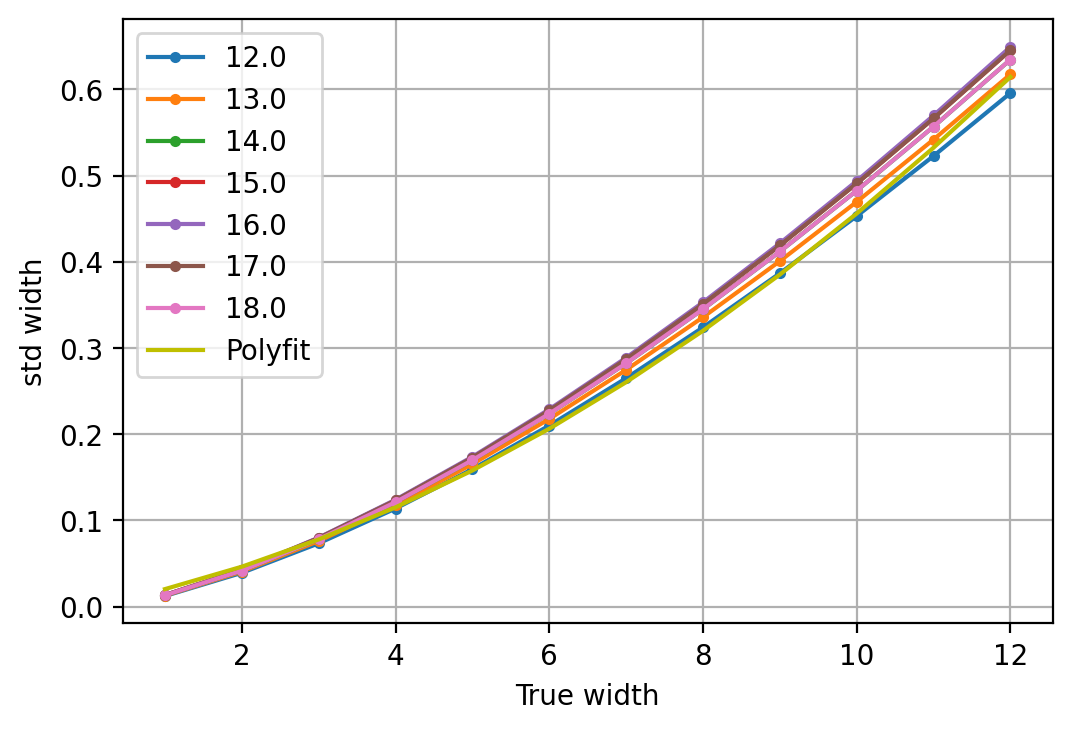

In [4]:
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

def createStripe(xPoints, position, trueWidth, dx, Nspace):
    conc = np.zeros(Nspace)
    conc[int((position-trueWidth)/dx):int((position+trueWidth)/dx)] = 1
    return conc

@njit('Tuple((f8,f8))(f8[:], f8[:])') # ref
def calcStripeAttributes(xPoints:np.ndarray, concProfile:np.ndarray) -> (float, float):
    """
    Calculates properties of the stripe.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - concProfile:np.ndarray: The concentration profile of the genes.
        
    Outputs:
        - pos:float: The position of the stripe.
        - width:float: The position of the stripe.
    """
    
    # Weighted mean (expectation value)
    pos = np.sum(xPoints*concProfile) / np.sum(concProfile)
    
    # Weighted standard deviation
    width = np.sqrt(np.sum(concProfile*(xPoints - pos)*(xPoints - pos)) 
                    / np.sum((xPoints - pos)*(xPoints - pos)))

    return pos, width


nump = 18-12 + 1
numw = 12-1 + 1
positions = np.linspace(12, 18, nump)
widths = np.linspace(1,12,numw)

a,b = 0.0028,0.0176

dx = 1e+0
Ncells = 32
Nspace = int(Ncells/dx)
xPoints = np.linspace(0, Ncells, Nspace)

concs = np.empty((nump, numw, Nspace))
calcPosWidths = np.empty((nump,numw,2))

for i,p in enumerate(positions):
    for j,w in enumerate(widths):
        concs[i,j] = createStripe(xPoints, p, w, dx, Nspace)
        calcPosWidths[i,j] = np.asarray(calcStripeAttributes(xPoints, concs[i,j]))
        
        
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
        
for p in range(len(positions)):
    ax.plot(widths, calcPosWidths[p,:,1], label=positions[p], marker='.')
ax.plot(widths, a*widths**2 + b*widths, label='Polyfit', c='y')
ax.grid()

# Creates appropiate labels
ax.set_xlabel('True width')
ax.set_ylabel('std width')
    
ax.legend(loc='best')
    
plt.show(fig)

Standard deviation is a faster calculation and it has a positive correlation with the true width clearly. So it can be used instead and is justified.

Changing the number of mutations from the number of selected mutations to number of true mutations.

### 06/07/22
Going to implement the ability to save the computed arrays and deviations so I don't need to simulate it every time.

Done trivially with `np.save` and `np.load`.

### 07/07/22
Running simulations for a long time to ensure convergence.

Many times they cannot converge as they are in a local minimum so need to increase mutation amount perhaps.


### 08/07/22
Need to only examine the final weights.

Will create a distribution of the final weights.

Will create the ability to vary multiple weights at a time.

In [3]:
import numpy as np
from time import perf_counter

mean = 5
std = 1e-1
N = int(1e+6)

start = perf_counter()
for k in range(N):
    x = np.random.normal(mean, std)
end = perf_counter()
print(f'normal: {end-start} seconds')

start = perf_counter()
for k in range(N):
    x = std*np.random.randn() + mean
end = perf_counter()
print(f'randn: {end-start} seconds')

normal: 19.033820799999944 seconds
randn: 4.79885749999994 seconds


Always use `np.random.randn`.

### 09/07/22
Tried to implement more simultaneous mutations.

Cannot get it to converge.

In [ ]:
std = 1e-1
mean_std = 1

# Determine the position of the weights to vary (excluding morphogen input)
pos = np.argwhere(interactionWeights != 0)[1:]

# Determine how many weights to vary
prob = np.random.random()
numWeights = 1
for i in range(1, len(pos)):
    if prob < 5**(-i):
        numWeights = i+1
        continue
    else:
        break


# Determine which weight to vary
weightsToVary = np.random.choice(np.arange(0, len(pos), 1), size=numWeights, replace=False)

# weightToVary = pos[np.random.randint(len(pos))]
weights = np.copy(interactionWeights)

for i in weightsToVary:
    # Determine the percentage to vary by.
    amount = std*(mean_std + np.random.randn())

    sign = 1 if np.random.random() < 0.5 else -1 # ref
    weights[pos[i,0],pos[i,1]] += sign*amount*weights[pos[i,0],pos[i,1]]



### 10/07/22
Got M0 to converge.

Trying to implement the weight histograms.


In [1]:
def displayWeightDistributions(interactionWeights:np.ndarray, weightHistories:np.ndarray):
    """
    Display the distribution of the final weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
    """
    
    weightPositions = np.argwhere(interactionWeights!=0)[1:]
    numOfWeights = np.shape(weightPositions)[0]  
    
    # Creates an array of the final weights
    weights = np.empty((np.shape(weightHistories)[0],3,4))
    for i,weightHistory in enumerate(weightHistories):
        weights[i] = weightHistory[weightHistory[:,0,0]!=-1][-1]
    
    # Create weight distribution analysis
    fig = plt.figure(figsize=(8,2*numOfWeights), tight_layout=True)
    
    
    for i in range(numOfWeights):
        ax = fig.add_subplot(int(np.ceil(numOfWeights/2)), 2, i+1)
        counts, bins = np.histogram(weights[:,weightPositions[i,0], weightPositions[i,1]], bins=10)
        ax.hist(bins[:-1], bins, weights=counts)
        
        # Creates appropiate labels
        ax.set_title(str(weightPositions[i]))
        ax.set_xlabel('final weight')
        ax.set_ylabel('frequency')
        
    plt.show(fig)

NameError: name 'np' is not defined

## 12/07/22-19/07/22
### 12/07/22
Able to get convergence for M0, M2, M3 (but long time) and M5 (short time).

Will create a function to find a random nearby set of weights that also cause a stripe and rerun the evolution process to see if it still converges.

Instead can just print out a set of interactionWeights from the deviation calculation.

### 13/07/22
Creating a new data analysis file.

Updated the pairwise correlation function.

In [2]:
def pairwiseCorrelationAnalysis(interactionWeights:np.ndarray, weightHistories:np.ndarray):
    """
    Displays plots to find correlations between weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
    """

    
    weightPositions = np.argwhere(interactionWeights!=0)[1:]
    numOfWeights = np.shape(weightPositions)[0]    
    
    # Creates pairwise correlation analysis
    fig = plt.figure(figsize=(14,12), tight_layout=True)
    fig.suptitle('Pairwise correlation of interaction weights')
    # Creates an array of the final weights
    weights = np.empty((np.shape(weightHistories)[0],3,4))
    for i,weightHistory in enumerate(weightHistories):
        weights[i] = weightHistory[weightHistory[:,-1,-1]!=-1][-1]
    
    for i in range(numOfWeights):
        for j in range(numOfWeights):
            x = weights[:, weightPositions[i,0], weightPositions[i,1]]
            y = weights[:, weightPositions[j,0], weightPositions[j,1]]
            
            ax = fig.add_subplot(numOfWeights,numOfWeights,i + numOfWeights*j + 1)
                
            # Line of best fit
            if i==j:
                ax.grid()
                # Displays scatter plot            
                ax.scatter(x, y, marker='.', c='g')
            elif i < j:
                ax.grid()
                # Displays scatter plot            
                ax.scatter(x, y, marker='.', c='g')
                
                x_diff = x - np.mean(x)
                y_diff = y - np.mean(y)
                
                
                residualSum = np.sum(x_diff*y_diff) / np.sqrt(np.sum(x_diff*x_diff)*np.sum(y_diff*y_diff))
                
                if abs(residualSum) > 0.5:
                    # Plots correlation
                    ax.text(0.01,0.01, f"r = {residualSum}", transform=plt.gca().transAxes)
                    para, cvm = curve_fit(lambda z,m,c: m*z + c, x, y)
                    lineY = para[0]*x + para[1]
                    ax.plot(x, lineY)
            elif i > j:
                # Citation: https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/
                ########################
                nbins = 50


                K = kde.gaussian_kde([x, y])
                xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
                zi = K(np.vstack([xi.flatten(), yi.flatten()]))
                axesRanges = (x.min(), x.max(), y.min(), y.max())
                ratio = (axesRanges[1] - axesRanges[0]) / (axesRanges[3] - axesRanges[2])

                # Creates contour plot
                im = ax.imshow(zi.reshape(xi.shape), cmap='Reds',
                               origin='lower', extent=axesRanges, aspect=ratio)
                # ax.contourf(xi, yi, zi.reshape(xi.shape), cmap='binary' )
                #########################
                
            # Creates appropiate labels
            if i==0:
                ax.set_ylabel(str(weightPositions[j]), color='purple', size='large')
            if j==0:
                ax.set_title(str(weightPositions[i]), color='purple', size='large')
    
    plt.show(fig)

NameError: name 'np' is not defined

Frozen oscillator graph showed that I was removing the wrong axis of weights when mutating. Fixing this.

In [4]:
# Determine the position of the weights to vary (excluding morphogen input)
pos = np.argwhere(interactionWeights[:,1:] != 0)
pos[:,1] += 1 

NameError: name 'np' is not defined

### 14/07/22
Making custom legends

In [9]:
# Custom legend # ref
startPoint = mlines.Line2D([], [], color='cyan', marker='o', linestyle='None',
                      label='Start point')
newStartPoint = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                      label='Start point')
mutatedPoint = mlines.Line2D([], [], color='orange', marker='.', linestyle='None',
                      label='Mutated point')
firstMutatedPoint = mlines.Line2D([], [], color='blue', marker='.', linestyle='None',
                      label='First iteration mutated point')
finalPoint = mlines.Line2D([], [], color='purple', marker='.', linestyle='None',
                      label='Final point')
firstFinalPoint = mlines.Line2D([], [], color='lime', marker='.', linestyle='None',
                      label='First iteration final point')
ax.legend(handles=[startPoint, mutatedPoint, finalPoint,
                   newStartPoint, firstMutatedPoint, firstFinalPoint], loc='best')

NameError: name 'mlines' is not defined

No longer going to use weight since overlapping domains (M4) will not converge so it will be excluded from the investigation.

Deleting:

In [10]:
def analyseWeights(weightRanges:tuple, weightsToVary:np.ndarray, morphogenProfile:np.ndarray, 
                   interactionWeights:np.ndarray,
                   xPoints:np.ndarray,
                   dx:float, dt:float, Ncells:int, Nspace:int, Nsteps:int,
                   diffConsts:np.ndarray, decayConst:float, dissociationConsts:np.ndarray
                   , showProgress:bool=True):
    """
    Creates a figure of the varying dissociation constants in two genes.
    
    Inputs:
        - weightRanges:tuple: The ranges to investigate
        - weightsToVary:np.ndarray: Indicies of two weights to vary. Of shape (2,3).
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - showProgress:bool: Determines if the progress should be displayed.
    """
    
    # Determines the frequency with which samples are taken
    snapshotPeriod = int(Nsteps-2)
    
    weight_rangeX = weightRanges[0:2]
    weight_rangeY = weightRanges[2:4]
    
    numx = 5
    numy = 5
    
    precision = np.max(int(np.log10(abs(weightRanges[weightRanges!=0])))+1) # ref
    
    weight_x = np.round(np.linspace(weight_rangeX[0], weight_rangeX[1], numx), precision+2)
    weight_y = np.round(np.linspace(weight_rangeY[0], weight_rangeY[1], numy), precision+2)
    
    sampleWeights = np.zeros((numx, numy, 3, 4))
    sampleWeights[:,:] = interactionWeights
    
    for i in range(numx):
        sampleWeights[i,:,weightsToVary[0,0],weightsToVary[0,1]] = weight_x
        
    for i in range(numy):
        sampleWeights[:,i,weightsToVary[1,0],weightsToVary[1,1]] = weight_y
        
                
    concProfiles = np.empty((numx,numy,3,Nspace))    
    
    startTime = perf_counter()
    for i,weight_clump in enumerate(sampleWeights):
        for j, weight in enumerate(weight_clump):
            concProfiles[i,j] = calculateGeneHistory(xPoints, morphogenProfile, weight, dx, dt,
                                                     Ncells, Nspace, Nsteps,
                                                     diffConsts, decayConst, 1,
                                                     snapshotPeriod, dissociationConsts)[:,-1]
            
        if showProgress:
            print(f'Progress: {100*(i+1)//numx}%')
        
    endTime = perf_counter()
    
    print(f'Calculations took {endTime - startTime} seconds')
    
    displayDissConstFigure(xPoints, dt, weight_x, weight_y, numx, numy,
                           weightsToVary, concProfiles, Nsteps,
                           morphogenProfile, interactionWeights)
    
    
    
def displayDissConstFigure(xPoints:np.ndarray, dt:float, weight_x:np.ndarray, weight_y:np.ndarray,
                           numx:int, numy:int, weightsToVary:tuple,
                           concProfiles:np.ndarray, Nsteps:int,
                           morphogenProfile:np.ndarray, interactionWeights:np.ndarray):
    """
    Displays a figure of the concentration profiles with varying values of a dissociation constant for two genes.
    
    Inputs:
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dt:float: Time step
        - weight_x:np.ndarray: x-range of weights.
        - weight_y:np.ndarray: y-range of weights.
        - numx:int: The number of phiRatios of the first gene.
        - numy:int: The number of phiRatios of the second gene.
        - weightsToVary:tuple: Indicies of the two weights to vary.
        - concProfiles:np.ndarray: The concentration profiles of all genes for all dissociation constants.
        - Nsteps:int: Number of time steps.
        - decayConst:float: Decay constant for the system.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
    """
    
    fig = plt.figure(figsize=(numx*2, numy*1.8), dpi=300, tight_layout=True)
    # Creates figure labels
    fig.suptitle(f'Concentration profiles for various interaction weights at t={dt*(Nsteps-2)} and'
                 + f' base weight matrix \n{interactionWeights}')
    fig.supxlabel(f'Weight {weightsToVary[0]}', color='purple')
    fig.supylabel(f'Weight {weightsToVary[1]}', color='purple')
    # fig.add_axes(np.ones(4))
        
    for i,px in enumerate(weight_x):
        for j,py in enumerate(weight_y):
            ax = fig.add_subplot(numx, numy, i*numx + j + 1)
            # Plots morphogen profile
            ax.plot(xPoints, morphogenProfile, c='orange', label='morphogen input')
            # Creates plot of all three genes
            for c in range(3):
                ax.plot(xPoints, concProfiles[i,j,c], c=geneIndexTranslation[c], marker='.', markersize=2.5)
            ax.grid(axis='y')
            
            # Creates appropiate labels
            ax.set_ylim(bottom=-0.1)
            if j==0:
                ax.set_ylabel(weight_y[i], color='purple', size='large')
            if i==numx-1:
                ax.set_xlabel(weight_x[j], color='purple', size='large')
            # ref
            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

    # Adds figure legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right')
            
            
    plt.show(fig)

In [11]:
variableWeights = np.copy(interactionWeights)
for w1 in np.linspace(0.1, 1.5, 3):
    for w2 in np.linspace(-1.5, -0.1, 3):
        for w3 in np.linspace(0.1, 1.5, 3):
            print('w1 =',w1)
            print('w2 =',w2)
            print('w3 =',w3)
            variableWeights[0,0] = w1
            variableWeights[0,3] = w2
            variableWeights[1,0] = w3
            analyseWeights((-1.5,-0.1,0.1,1.5), np.asarray(((2,1), (2,2))), morphogenProfile,
                           variableWeights, xPoints,
                           dx, dt, Ncells, Nspace, Nsteps,
                           diffConsts, decayConst, dissociationConsts, True)

NameError: name 'interactionWeights' is not defined

Merging histograms into pairwise correlation plots.

Changing rerunning to starting at the same point.

Removing individual set of histograms of weights.

Deleting:

In [12]:
def displayWeightDistributions(interactionWeights:np.ndarray, weightHistories:np.ndarray):
    """
    Display the distribution of the final weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
    """
    
    weightPositions = np.argwhere(interactionWeights!=0)[1:]
    numOfWeights = np.shape(weightPositions)[0]  
    
    # Creates an array of the final weights
    weights = np.empty((np.shape(weightHistories)[0],3,4))
    for i,weightHistory in enumerate(weightHistories):
        weights[i] = weightHistory[weightHistory[:,-1,-1]!=-1][-1]
    
    # Create weight distribution analysis
    fig = plt.figure(figsize=(8,2*numOfWeights), tight_layout=True)
    
    
    for i in range(numOfWeights):
        ax = fig.add_subplot(int(np.ceil(numOfWeights/2)), 2, i+1)
        counts, bins = np.histogram(weights[:,weightPositions[i,0], weightPositions[i,1]], bins=10)
        ax.hist(bins[:-1], bins, weights=counts, color='brown')
        
        # Creates appropiate labels
        ax.set_title(str(weightPositions[i]))
        ax.set_xlabel('final weight')
        ax.set_ylabel('frequency')
        
    plt.show(fig)


May change pairwise correlation to weight difference.

Need to change axes labels so they are meaningful with respect to the mechanism structure.

Need to look at decreaseing the spacial step for the classical mechanism (M2) to try to see if descretness is inherrent in the system or an error.

In [13]:
def getLabel(interactionWeights:np.ndarray, weightPosition:np.ndarray) -> str:
    """
    Maps the weights to the mechanism structure
    
    Inputs:
        - interactionWeights:np.ndarray: The weights applied from the mechanism.
        - weightPosition:np.ndarray: The indecies of the weights to transform.
    Return:
        - weightLabel:str: The label corresponding to the weights.
    """
    if interactionWeights[weightPosition[0], weightPosition[1]] < 0:
        effectType = '|'
    else:
        effectType = '>'
        
    weightLabel = str(weightPosition[1]) + ' --' + effectType + ' ' + str(weightPosition[0]+1)
    
    return weightLabel

### 15-18/07/22
Have been trying to simulate more, however some are very difficult to converge.

M1' takes too long to converge.

Need to look at why M2 and M5 are so discrete. Can do this be decreaseing the spacial step. However, the number of time steps is inversly proportional to the square of the spacial step.

Halfing the spacial step has shown that discretness is a product of the approximation not the system. Takes twice as long though.

Could create a flow diagram of weights. Generate a change in weight matrix for all weights for all reruns. Have these as vectors on a weight-time graph with positions being the weights.

In [1]:
def createFlowVectors(interactionWeight:np.ndarray, weightHistories:np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Generates the difference between consecutive weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
    Outputs:
        - weightDifferences:np.ndarray: The difference between consecutive weights.
        - numOfAcceptedMutations:np.ndarray: The number of accepted mutations.
    """
    
    # Finds the positions of the weights which are varied
    weightPositions = np.argwhere(interactionWeights[:,1:]!=0)
    weightPositions[:,1:] += 1
    numOfWeights = np.shape(weightPositions)[0]   
    
    
    weightDifferences = np.zeros((len(weightHistories), int(max(numOfMutations))-1, 3, 4))

    
    weightsToInclude = list(map(lambda x: x[:,0,0]!=-1, weightHistories))
    numOfAcceptedMutations = np.sum(weightsToInclude, axis=1)
    
    # Calculate the weight difference
    for i,weightHistory in enumerate(weightHistories):
        weightDifferences[i,:int(numOfAcceptedMutations[i]-1)] = (weightHistory[weightsToInclude[i]] 
                                                        - np.roll(weightHistory[weightsToInclude[i]], 1, axis=0))[:-1]
    
    
    
    
    
    
    
    return weightDifferences, numOfAcceptedMutations
    
    
    
def displayFlowVectors(interactionWeights:np.ndarray, weightHistories:np.ndarray,
                       weightDifferences:np.ndarray, numOfAcceptedMutations:np.ndarray):
    """
    Displays the flow of weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
        - weightDifferences:np.ndarray: The difference between consecutive weights.
        - numOfAcceptedMutations:np.ndarray: The number of accepted mutations.
    """
    
    # Finds the positions of the weights which are varied
    weightPositions = np.argwhere(interactionWeights[:,1:]!=0)
    weightPositions[:,1:] += 1
    numOfWeights = np.shape(weightPositions)[0] 
    
    weightsToInclude = list(map(lambda x: x[:,0,0]!=-1, weightHistories))
    
    fig = plt.figure(figsize=(8,4*int(np.ceil(numOfWeights/2))), tight_layout=True)
    
    
    for i in range(numOfWeights):
        ax = fig.add_subplot(int(np.ceil(numOfWeights/2)), 2, i+1)
        ax.grid()
        for j,weightHistory in enumerate(weightHistories):
            ax.plot(np.arange(numOfAcceptedMutations[j]),
                    weightHistory[weightsToInclude[j]][:,weightPositions[i,0], weightPositions[i,1]],
                    color='orange', marker='.', zorder=1)
            ax.scatter(numOfAcceptedMutations[j]-1,
                       weightHistory[weightsToInclude[j]][-1,weightPositions[i,0], weightPositions[i,1]],
                       color='purple', marker='.', zorder=2)
            
        
        
        # Create appropiate labels
        ax.set_xlabel('number of mutations')
        ax.set_ylabel('weight amount')
        weightLabel = getLabel(interactionWeights, weightPositions[i])
        ax.set_title(weightLabel)
        
        
    plt.show(fig)

NameError: name 'np' is not defined

## 19/07/22-26/07/22
### 19/07/22

Am going to try to create a flow diagram of the trait historie with the starting point being the source and the end point being the sink.

The vectors can be represented as the difference between the phenotypes.

Need to create an algorithm to determine which tile a given point is in and then add data to an element corrisponding to the tile's position.

Going to do this by finding the difference between each phenotype component and then the corresponding minimum of these.


M5:dx=0.5 cannot reach stability most of the time.

In [3]:
def calculateTraitField(traitHistories:np.ndarray, initialPhenotypes:np.ndarray,
                        units:np.ndarray, position_aim:float=None, width_aim:float=None) -> (np.ndarray,
                                                                                            np.ndarray,
                                                                                            np.ndarray,
                                                                                            np.ndarray):
    """
    Displays the traits through time as a flow diagram.
    
    Inputs:
        - traitHistory:np.ndarray: The history of the widths and positions of the stripes.
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
        
    Outputs:
        - X:np.ndarray: Coordinates of the positions being sampled.
        - Y:np.ndarray: Coordinates of the widths being sampled.
        - U:np.ndarray: Average position differences.
        - V:np.ndarray: Average width differences.
    """
    
    meshLength = 20
    
    # Finds the maximum and minimum positions and widths.
    domain = list(map(lambda x: x[:,0]!=-1, traitHistories))
    extrema = np.transpose([np.min(traitHistories[domain], axis=0), np.max(traitHistories[domain], axis=0)])
    
    x = np.linspace(extrema[0,0], extrema[0,1], meshLength)
    y = np.linspace(extrema[1,0], extrema[1,1], meshLength)
    
    x2D, y2D = np.meshgrid(x, y)
    
    traitDifferences = np.zeros((len(traitHistories), int(max(numOfMutations))-1, 2))

    
    numOfAcceptedMutations = np.sum(domain, axis=1, dtype=int)
    
    # Calculate the trait differences
    for i,traitHistory in enumerate(traitHistories):
        traitDifferences[i,:int(numOfAcceptedMutations[i]-1)] = (traitHistory[domain[i]] 
                                                        - np.roll(traitHistory[domain[i]], 1, axis=0))[:-1]
    U,V = averageDifferences(x, y, traitHistories, traitDifferences, meshLength,numOfAcceptedMutations, domain)
    
    return x2D,y2D,U,V
    
    
    
def averageDifferences(x:np.ndarray, y:np.ndarray, traitHistories:np.ndarray, traitDifferences:np.ndarray,
                      meshLength:int, numOfAcceptedMutations:np.ndarray, domain:np.ndarray) -> (np.ndarray,
                                                                                               np.ndarray):
    """
    Determines the vector field of the average differences in phenotypes.
    
    Inputs:
        x:np.ndarray: The available positions.
        y:np.ndarray: The available widths.
        traitHistories:np.ndarray: The histories of the phenotypes.
        traitDifference:np.ndarray: The differences between consecutive phenotypes.
        meshLength:int: The length of one side of the mesh.
        numOfAcceptedMutations:np.ndarray: The number of mutations which are accepted.
        domain:np.ndarray: An array of the elements which have data in them.
    
    Outputs:
        - U:np.ndarray: The average position differences.
        - V:np.ndarray: The average weight differences.
    """
    
    U = np.zeros((meshLength, meshLength))
    V = np.zeros((meshLength, meshLength))
    num = np.zeros((meshLength, meshLength), dtype=int)
    

    # componentDifferences = traitHistories - x,y
    componentDifference = np.empty((2, meshLength))
        
    for i,traitHistory in enumerate(traitHistories):
        for m in range(numOfAcceptedMutations[i]-1):
            # Finds the differences in each component.
            componentDifference[0] = abs(traitHistory[domain[i]][m,0] - x)
            componentDifference[1] = abs(traitHistory[domain[i]][m,1] - y)
            
            # Minimum difference positions
            minDiff = np.min(componentDifference, axis=1)
            coord = (np.where(minDiff[0]==componentDifference[0]),np.where(minDiff[1]==componentDifference[1]))
            
            U[coord] += traitDifferences[i,m,0]
            V[coord] += traitDifferences[i,m,1]
            num[coord] += 1
            
    # Calculate the average.
    for i in range(meshLength):
        for j in range(meshLength):
            if U[i,j]!=0:
                U[i,j] /= num[i,j]
                V[i,j] /= num[i,j]
    
    
    return U,V

NameError: name 'np' is not defined

In [4]:
def displayTraitField(X:np.ndarray,Y:np.ndarray,U:np.ndarray,V:np.ndarray, initialPhenotypes:np.ndarray,
                        units:np.ndarray, position_aim:float=None, width_aim:float=None):
    """
    Displays the variation of phenotypes as a flow diagram.
    
    Inputs:
        - X:np.ndarray: Coordinates of the positions being sampled.
        - Y:np.ndarray: Coordinates of the widths being sampled.
        - U:np.ndarray: Average position differences.
        - V:np.ndarray: Average width differences.
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
    """
    
    distance = np.hypot((initialPhenotypes[0]-position_aim)/units[0],
                        (initialPhenotypes[1]-width_aim)/units[1])
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    # Displays start point
    ax.scatter(initialPhenotypes[0], initialPhenotypes[1], marker='o', color='cyan')
    
#     ax.streamplot(X,Y,U,V, density=0.5, color='orange')
    ax.quiver(X,Y,U,V, color='orange')
    
    # Displays aim
    if position_aim != None and width_aim != None:
        ax.scatter(position_aim, width_aim, marker='o', color='red')
        # Creates convergence threshold circle
        angle = np.linspace(0,2*np.pi,100)
        ax.plot(position_aim + phenotypeThreshold*np.cos(angle)*units[0],
                width_aim + phenotypeThreshold*np.sin(angle)*units[1], color='red')
    elif position_aim != None:
        ax.axvline(position_aim, color='red')
    elif width_aim != None:
        ax.axhline(width_aim, color='red')
        
        
    ax.grid()
    
    
    # Creates appropiate labels
    ax.set_xlabel('position [cell]')
    ax.set_ylabel(r'width [$\sigma$]')
    ax.set_title(f'Variation of traits after consecutive mutations with\n distance={round(distance,3)}')
    
 
    
    
    plt.show(fig)

NameError: name 'np' is not defined

Seems to be an issue with this as the magnitude nor position of the vectors are remotely correct.

#### Discussion with Zena.
* For M0 create a graph of average weight difference vs distance from phenotype aim.
* Continue with the flow diagram.
* Prioritise two page report and presentation.
* Make two figures for the IPLS report, one for the theory and one for the results.


Do not need the DD analysis anymore.

Deleting:

In [ ]:
def distance_directionAnalysis(initialPhenotypes:np.ndarray, numOfIterations:int,
                               numOfSamples:int, numOfRepeats:int,
                               positionRange:np.ndarray, widthRange:np.ndarray,
                               interactionWeights:np.ndarray,
                               morphogenProfile:np.ndarray, xPoints:np.ndarray, 
                               dx:float, dt:float, Ncells:int, Nspace:int,
                               Nsteps:int, diffConsts:np.ndarray, decayConst:float,
                               dissociationConsts:np.ndarray,
                               deviationUncertainties:np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Determines how the time to converge depends on the distance and direction of the selected phenotype.
    
    Inputs:
        - initialPhenotypes:np.ndarray: The initail characteristics of the stripe.
        - numOfIterations:int: Number of allowed mutations.
        - numOfSamples:int: Number of selected phenotypes in each access.
        - numOfRepeats:int: Number of repeat readings.
        - positionRange:np.ndarray: The bounds of the position.
        - widthRange:np.ndarray: The bounds of the width.
        - interactionWeights:np.ndarray: Weights associated with the mechanism type.
        - morphogenProfile:np.ndarray: The morphogen concentration profile.
        - xPoints:np.ndarray: x coordinates of the points being sampled.
        - dx:float: Spatial step.
        - dt:float: Time step.
        - Ncells:int: The number of cells used.
        - Nspace:int: The number of spatial points used.
        - Nsteps:int: The number of time steps used.
        - diffConsts:np.ndarray: An array of diffusion constants for the genes.
        - decayConst:float: Decay constant for the system.
        - dissociationConsts:np.ndarray: Value to adjust the regulatory function by for each gene.
        - deviationUncertainties:np.ndarray: Used for unit adjustment.
        
    Outputs:
        - averageTimes:np.ndarray: The average time to converge.
        - averageStd:np.ndarray: The standard deviations of the times to converge.
    
    """
    
    position_aims = np.linspace(positionRange[0], positionRange[1], numOfSamples)
    width_aims = np.linspace(widthRange[0], widthRange[1], numOfSamples)
    
    averageTimes = np.empty((2, numOfSamples))
    stdTimes = np.empty((2, numOfSamples))
    
    # Position variation
    width_aim = initialPhenotypes[1]
    for i,position_aim in enumerate(position_aims):
        numOfMutations = rerunLoop(
                            numOfRepeats, numOfIterations, interactionWeights,
                            morphogenProfile, xPoints, 
                            dx, dt, Ncells, Nspace,
                            Nsteps, diffConsts, decayConst,
                            dissociationConsts, position_aim=position_aim,
                            width_aim=width_aim, position_units=deviationUncertainties[0],
                            width_units=deviationUncertainties[1])[2]

        averageTimes[0,i] = np.mean(numOfMutations)
        stdTimes[0,i] = np.std(numOfMutations)
          
            
    print('Halfway')
    # Width variation
    position_aim = initialPhenotypes[0]
    for i,width_aim in enumerate(width_aims):
        numOfMutations = rerunLoop(
                            numOfRepeats, numOfIterations, interactionWeights,
                            morphogenProfile, xPoints, 
                            dx, dt, Ncells, Nspace,
                            Nsteps, diffConsts, decayConst,
                            dissociationConsts, position_aim=position_aim,
                            width_aim=width_aim, position_units=deviationUncertainties[0],
                            width_units=deviationUncertainties[1])[2]
            
        averageTimes[1,i] = np.mean(numOfMutations)
        stdTimes[1,i] = np.std(numOfMutations)
            
            
    return averageTimes, stdTimes
            
            
        
def displayDDAnalysis(averageTimes:np.ndarray, stdTimes:np.ndarray,
                      initialPhenotypes:np.ndarray, positionRange:np.ndarray, 
                      widthRange:np.ndarray, numOfSamples:int):
    """
    Displays the results of the distance-direction convergence analysis.
    
    Inputs:
        - averageTimes:np.ndarray: The average time to converge.
        - averageStd:np.ndarray: The standard deviations of the times to converge.
        - initialPhenotypes:np.ndarray: The initail characteristics of the stripe.
        - positionRange:np.ndarray: The bounds of the position.
        - widthRange:np.ndarray: The bounds of the width.
        - numOfSamples:int: Number of selected phenotypes in each access.
    """
    
    
    fig = plt.figure(figsize=(10,6), tight_layout=True)
    
    # Position variation
    ax = fig.add_subplot(1,2,1)
    ax.errorbar(np.linspace(positionRange[0], positionRange[1],numOfSamples) - initialPhenotypes[0],
                averageTimes[0], yerr=stdTimes[0], capsize=5, marker='o')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel('position difference / cell')
    ax.set_ylabel('time to converge / number of mutations')
    ax.set_title('Convergence times for variation of selected position\n'
                 + f'phenotype with width_aim={initialPhenotypes[1]}')
    
    # Width variation
    ax = fig.add_subplot(1,2,2)
    ax.errorbar(np.linspace(widthRange[0], widthRange[1],numOfSamples) - initialPhenotypes[1],
                averageTimes[1], yerr=stdTimes[1], capsize=5, marker='o')
    ax.grid()
    # Creates appropiate labels
    ax.set_xlabel(r'width difference / $\sigma$')
    ax.set_ylabel('time to converge / number of mutations')
    ax.set_title('Convergence times for variation of selected width\n'
                 + f'phenotype with position_aim={initialPhenotypes[0]}')

In [ ]:

positionRanges = np.asarray([[12.,18.], [13.,17.], [9.,21.], [13.,18.], [0.,0.], [12.,18.]])
widthRanges = np.asarray([[0.3,0.5], [0.1,1.5], [0.1,2.4], [0.1,1.0], [0.,0.], [0.,0.54]])

numOfSamples = 10
numOfIterations = 300

# pos_range = positionRanges[mechanismIndex]
# width_range = widthRanges[mechanismIndex]

pos_range = [initialPhenotypes[0] - deviationUncertainties[0],
                                                    initialPhenotypes[0] + deviationUncertainties[0]]
width_range = [initialPhenotypes[1] - deviationUncertainties[1],
                                                    initialPhenotypes[1] + deviationUncertainties[1]]

if writeDDAnalysis:
    start_time = perf_counter()
    averageTimes, stdTimes = distance_directionAnalysis(initialPhenotypes, numOfIterations,
                                                       numOfSamples, 5,
                                                       pos_range, 
                                                       width_range,
                                                       interactionWeights,
                                                       morphogenProfile, xPoints, 
                                                       dx, dt, Ncells, Nspace,
                                                       Nsteps, diffConsts, decayConst,
                                                       dissociationConsts,
                                                       deviationUncertainties)

    end_time = perf_counter()


    print(f'Simulation took: {(end_time - start_time)/60} minutes.')
    
    # Write to file
    np.save(f'DDAnalysis{mechanismIndex}.npy', (averageTimes, stdTimes))
    
else:
    averageTimes, stdTimes = np.load(f'DDAnalysis{mechanismIndex}.npy')

In [5]:
displayDDAnalysis(averageTimes, stdTimes, initialPhenotypes, pos_range, 
                                                   width_range, numOfSamples)

NameError: name 'displayDDAnalysis' is not defined

The GP graph no longer makes sense in the given context.

Deleting:

In [6]:
def GP_comparisonGraph(units:np.ndarray, traitHistories:np.ndarray, weightHistories:np.ndarray):
    """
    Creates a graph to compare the genotypes and phenotypes reached to determine how convergent evolution is.
    
    Inputs:
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - traitHistories:np.ndarray: The history of the widths and positions of the stripes.
        - weightHistories:np.ndarray: The history of the weights creating the stripes. 
    """
    
    
    matrixDifference = np.asarray(list(map(lambda x: x[x[:,0,0]!=-1][-1], weightHistories)))
    matrixDifference -= matrixDifference[0]
    lastWeightDifference = np.fromiter(map(lambda x: np.trace(x@x.T), matrixDifference), float) # ref
    
    vectorDifference = np.asarray(list(map(lambda x: x[x[:,0]!=-1][-1], traitHistories)))
    vectorDifference -= vectorDifference[0]
    lastTraitDifference = np.hypot(vectorDifference[:,0]/units[0], vectorDifference[:,1]/units[1]).T
    
    
    # Create figure
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.scatter(lastWeightDifference[1:], lastTraitDifference[1:], marker='.')
    ax.grid()
    
    
    # Creates appropiate labels
    ax.set_xlabel(r'genotype difference / $\Delta w$')
    ax.set_ylabel(r'phenotype difference / $\Delta T$')
    ax.set_title('Graph showing how frequent certain genotypes\n are reached compared to particular phenotypes.')
    
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    plt.show(fig)

NameError: name 'np' is not defined

Can also compare weight line equations and final weight distributions.


Going to create a figure to display the line parameters on the top graph (with uncertainties). With the mean and standard deviation on the bottom graph perhaps. Or will look into Kolmogorov-Smirnov statistics.

### 20/07/22
Created functions to analyse the parameters of the fitted lines in weight correlations for different distances.

In [7]:
def lineCorrelationComparison(mechanismIndex:int, numOfDistances:int, weightPositions:np.ndarray,
                              numOfWeights:int) -> (np.ndarray,np.ndarray,list):
    """
    Determine the mean and standard deviation of the final weights.
    
    Inputs:
         - mechanismIndex:int: The mechanism to analyse.
         - numOfDistances:int: The number of samples available.
         - weightPositions:np.ndarray: Positions of the weights.
         - numOfWeights:int The number of weights to vary.
         
    Outputs:
        - parameters:np.ndarray: The fitted parameters
        - parameter_uncertainties:np.ndarray: The uncertainty of the parameters.
        - arrayEntries:list: The non-zero entries of the array.
    """
    
    parameters = np.zeros((numOfWeights,numOfWeights,numOfDistances,2))
    parameter_uncertainties = np.zeros((numOfWeights,numOfWeights,numOfDistances,2))
    parameterEntries = []
    
    for subIndex in range(numOfDistances):
        # Load data
        weightHistories = np.load(f'weightHistories{mechanismIndex}_{subIndex}.npy')
    
        # Creates an array of the final weights
        weights = np.empty((np.shape(weightHistories)[0],3,4))
        for i,weightHistory in enumerate(weightHistories):
            weights[i] = weightHistory[weightHistory[:,0,0]!=-1][-1]


        # Loop through all combinations of weights.
        for w1 in range(numOfWeights):
            for w2 in range(w1):

                x = weights[:, weightPositions[w1,0], weightPositions[w1,1]]
                y = weights[:, weightPositions[w2,0], weightPositions[w2,1]]

                # Determines the Pearson correlation coefficient
                x_diff = x - np.mean(x)
                y_diff = y - np.mean(y)
                residualSum = np.sum(x_diff*y_diff) / np.sqrt(np.sum(x_diff*x_diff)*np.sum(y_diff*y_diff))

                if abs(residualSum) > residualCutoff:
                    para, cvm = curve_fit(lambda inputs,m,c: m*inputs + c, x, y)
                    parameters[w1,w2,subIndex] = para
                    parameter_uncertainties[w1,w2,subIndex] = np.asarray([cvm[i,i] for i in range(2)])
                    parameterEntries.append([w1,w2,subIndex])
                    
    if len(parameterEntries)==0:
        print('No significant correlations')
    
    
    
    return parameters, parameter_uncertainties, np.asarray(parameterEntries)
    
    
def displayLineCorrelation(parameters:np.ndarray, parameter_uncertainties:np.ndarray, parameterEntries:np.ndarray,
                          distances:np.ndarray, weightPositions:np.ndarray, interactionWeights:np.ndarray):
    """
    Displays the correlation between fitted parameters for different distances.
    
    Inputs:
        - parameters:np.ndarray: The fitted parameters
        - parameter_uncertainties:np.ndarray: The uncertainty of the parameters.
        - arrayEntries:list: The non-zero entries of the array.
        - distances:np.ndarray: The distances of the samples.
        - weightPositions:np.ndarray: Positions of the weights.
        - interactionWeights:np.ndarray: The initial weight matrix.
    """
    
    
    weightPairs = np.unique(parameterEntries[:,:-1], axis=0)

    fig = plt.figure(figsize=(4*len(weightPairs),2*len(weightPairs)), tight_layout=True, dpi=200)
    fig.suptitle('Fitted parameters for line ' + r'$w_2=m*w_1+c$' + ' for\n varying distances to selected phenotype')
    
    for i,weightPair in enumerate(weightPairs):
        # Creates the axis
        ax = fig.add_subplot(1,len(weightPairs),i+1)
        ax.grid()
        
        for pEnt in parameterEntries:
            # Determines if the sample had a correlation for the given weight pairs
            if all(pEnt[:-1]==weightPair):
                pEnt_tup = tuple(pEnt)
                ax.errorbar(parameters[pEnt_tup][0], parameters[pEnt_tup][1],
                            xerr=parameter_uncertainties[pEnt_tup][0],
                            yerr=parameter_uncertainties[pEnt_tup][1], label=round(distances[pEnt[-1]],3), marker='x')
                
        # Creates appropiate labels
        ax.set_xlabel('gradient / m')
        ax.set_ylabel('intercept / c')
        w1 = getLabel(interactionWeights, weightPositions[weightPair[0]])
        w2 = getLabel(interactionWeights, weightPositions[weightPair[1]])
        ax.set_title(w2 + ' against ' + w1)
    
    # Create legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='right')
        
    plt.show(fig)
                
        
    

NameError: name 'np' is not defined

In [8]:
displayLineCorrelation(parameters, parameter_uncertainties, parameterEntries, distances, weightPositions,
                       interactionWeights)

NameError: name 'displayLineCorrelation' is not defined

Need to display the trait field for different distances on one figure.

In [9]:
def displayAllTraitFields(mechanismIndex:int, units:np.ndarray,
                         position_aim:float, width_aim:float, numOfDistances:int, distances:np.ndarray):
    """
    Calculates and displays flow diagrams for all distances sampled.
    
    Inputs:
        - mechanismIndex:int: The mechanism used.
        - units:np.ndarray: The deviations in each phenotype component.
        - position_aim:float: The position being selected for.
        - width_aim:float: The width being selected for.
        - numOfDistances:int: The number of samples.
        - distances:np.ndarray: The distances from the selected phenotype sampled.
    
    """
    
    # Create setup arrays
    X = np.empty((numOfDistances, meshLength, meshLength))
    Y = np.empty_like(X)
    U = np.empty_like(X)
    V = np.empty_like(X)
    
    positionRange = position_aim*np.ones(2)
    widthRange = width_aim*np.ones(2)
    
    initialPhenotypes = np.empty((numOfDistances,2))
    boundaryOffset = 5e-1
    
    # Generate flow fields
    for subIndex in range(numOfDistances):
        # Load data
        traitHistories = np.load(f'traitHistories{mechanismIndex}_{subIndex}.npy')
        initialPhenotypes[subIndex] = np.copy(traitHistories[0,0])
    
        X[subIndex],Y[subIndex],U[subIndex],V[subIndex] = calculateTraitField(traitHistories,
                                                                              initialPhenotypes[subIndex], 
                    units, position_aim=position_aim, width_aim=width_aim)
        
        # Find ranges
        if positionRange[0] > np.min(X[subIndex]):
            positionRange[0] = np.min(X[subIndex])
        if positionRange[1] < np.max(X[subIndex]):
            positionRange[1] = np.max(X[subIndex])
            
        if widthRange[0] > np.min(Y[subIndex]):
            widthRange[0] = np.min(Y[subIndex])
        if widthRange[1] < np.max(Y[subIndex]):
            widthRange[1] = np.max(Y[subIndex])
            
            
        
    # Create figure
    rows = int(np.ceil(numOfDistances/3))
    fig = plt.figure(figsize=(12,4*rows), tight_layout=True)
        
    for subIndex in range(numOfDistances):
        ax = fig.add_subplot(rows,3,subIndex+1)
        ax.grid()
        # Displays start point
        ax.scatter(initialPhenotypes[subIndex,0], initialPhenotypes[subIndex,1], marker='o', color='cyan', zorder=2)

        ax.streamplot(X[subIndex],Y[subIndex],U[subIndex],V[subIndex], density=0.7, color='orange',zorder=1)
        ax.quiver(X[subIndex],Y[subIndex],U[subIndex]*units[1],V[subIndex]*units[0], color='purple',
                  scale=2e+1, pivot='mid', zorder=1)
        
        # Displays aim
        if position_aim != None and width_aim != None:
            ax.scatter(position_aim, width_aim, marker='o', color='red')
            # Creates convergence threshold circle
            angle = np.linspace(0,2*np.pi,100)
            ax.plot(position_aim + phenotypeThreshold*np.cos(angle)*units[0],
                    width_aim + phenotypeThreshold*np.sin(angle)*units[1], color='red', marker=None)
        elif position_aim != None:
            ax.axvline(position_aim, color='red')
        elif width_aim != None:
            ax.axhline(width_aim, color='red')


        # Creates appropiate labels
        ax.set_xlabel('position [cell]')
        ax.set_ylabel(r'width [$\sigma$]')
        ax.set_title(f'distance={round(distances[subIndex],3)}')

        ax.set_xlim(positionRange[0] - boundaryOffset*units[0], positionRange[1] + boundaryOffset*units[0])
        ax.set_ylim(widthRange[0] - boundaryOffset*units[1], widthRange[1] + boundaryOffset*units[1])
        
    
    plt.show(fig)
    
    

NameError: name 'np' is not defined

In [10]:
displayAllTraitFields(mechanismIndex, deviationUncertainties,
                         position_aim, width_aim, numOfDistances, distances)

NameError: name 'displayAllTraitFields' is not defined

Changed parameter graph to show both parameters vs distance.

### 21/07/22
No longer need the trait field for the single distance.

Deleting:

In [1]:
def displayTraitField(X:np.ndarray,Y:np.ndarray,U:np.ndarray,V:np.ndarray, initialPhenotypes:np.ndarray,
                        units:np.ndarray, position_aim:float=None, width_aim:float=None):
    """
    Displays the variation of phenotypes as a flow diagram.
    
    Inputs:
        - X:np.ndarray: Coordinates of the positions being sampled.
        - Y:np.ndarray: Coordinates of the widths being sampled.
        - U:np.ndarray: Average position differences.
        - V:np.ndarray: Average width differences.
        - units:np.ndarray: Units of threshold in both phenotype directions.
        - position_aim:float=None: The position to select for.
        - width_aim:float=None: The width to select for.
    """
    
    distance = np.hypot((initialPhenotypes[0]-position_aim)/units[0],
                        (initialPhenotypes[1]-width_aim)/units[1])
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    # Displays start point
    ax.scatter(initialPhenotypes[0], initialPhenotypes[1], marker='o', color='cyan')
    
    ax.streamplot(X,Y,U,V, density=0.9, color='orange')
    
    # Displays aim
    if position_aim != None and width_aim != None:
        ax.scatter(position_aim, width_aim, marker='o', color='red')
        # Creates convergence threshold circle
        angle = np.linspace(0,2*np.pi,100)
        ax.plot(position_aim + phenotypeThreshold*np.cos(angle)*units[0],
                width_aim + phenotypeThreshold*np.sin(angle)*units[1], color='red', marker=None)
    elif position_aim != None:
        ax.axvline(position_aim, color='red')
    elif width_aim != None:
        ax.axhline(width_aim, color='red')
        
        
    ax.grid()
    
    
    # Creates appropiate labels
    ax.set_xlabel('position [cell]', fontsize=14)
    ax.set_ylabel(r'width [$\sigma$]', fontsize=14)
    ax.set_title(f'Variation of traits after consecutive mutations with\n distance={round(distance,3)}', fontsize=14)
    
 
    
    
    plt.show(fig)
    

NameError: name 'np' is not defined

In [2]:
displayTraitField(X,Y,U,V, initialPhenotypes, 
                    deviationUncertainties, position_aim=position_aim, width_aim=width_aim)

NameError: name 'displayTraitField' is not defined

### 21/07/22
Wrote the two page report.

Made labels larger.

### 22/07/22
Weight flow diagram not needed.

Deleting:

In [5]:
def createFlowVectors(interactionWeight:np.ndarray, weightHistories:np.ndarray, weightPositions:np.ndarray,
                               numOfWeights:int) -> (np.ndarray, np.ndarray):
    """
    Generates the difference between consecutive weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
    Outputs:
        - weightDifferences:np.ndarray: The difference between consecutive weights.
        - numOfAcceptedMutations:np.ndarray: The number of accepted mutations.
        - weightPositions:np.ndarray: The positions of the weights to vary.
        - numOfWeights:int: The number of weights to vary.
    """  
    
    weightDifferences = np.zeros((len(weightHistories), int(max(numOfMutations))-1, 3, 4))

    
    domain = list(map(lambda x: x[:,0,0]!=-1, weightHistories))
    numOfAcceptedMutations = np.sum(domain, axis=1, dtype=int)
    
    # Calculate the weight difference
    for i,weightHistory in enumerate(weightHistories):
        weightDifferences[i,:(numOfAcceptedMutations[i]-1)] = (np.roll(weightHistory[domain[i]], -1, axis=0) 
                                                               - weightHistory[domain[i]])[:-1]

        
    return weightDifferences, numOfAcceptedMutations
    
    
    
def displayWeightChanges(interactionWeights:np.ndarray, weightHistories:np.ndarray,
                       weightDifferences:np.ndarray, numOfAcceptedMutations:np.ndarray, weightPositions:np.ndarray,
                               numOfWeights:int):
    """
    Displays the flow of weights.
    
    Inputs:
        - interactionWeights:np.ndarray: The initial interaction weights.
        - weightHistories:np.ndarray: History of all mutations for all runs.
        - weightDifferences:np.ndarray: The difference between consecutive weights.
        - numOfAcceptedMutations:np.ndarray: The number of accepted mutations.
        - weightPositions:np.ndarray: The positions of the weights to vary.
        - numOfWeights:int: The number of weights to vary.
    """
    
    weightsToInclude = list(map(lambda x: x[:,0,0]!=-1, weightHistories))
    
    fig = plt.figure(figsize=(8,4*int(np.ceil(numOfWeights/2))), tight_layout=True)
    
    
    for i in range(numOfWeights):
        ax = fig.add_subplot(int(np.ceil(numOfWeights/2)), 2, i+1)
        ax.grid()
        for j,weightHistory in enumerate(weightHistories):
            ax.plot(np.arange(numOfAcceptedMutations[j]),
                    weightHistory[weightsToInclude[j]][:,weightPositions[i,0], weightPositions[i,1]],
                    color='orange', marker='.', zorder=1)
            ax.scatter(numOfAcceptedMutations[j]-1,
                       weightHistory[weightsToInclude[j]][-1,weightPositions[i,0], weightPositions[i,1]],
                       color='purple', marker='.', zorder=2)
            
        
        
        # Create appropiate labels
        ax.set_xlabel('number of mutations', fontsize=14)
        ax.set_ylabel('weight amount', fontsize=14)
        weightLabel = getLabel(interactionWeights, weightPositions[i])
        ax.set_title(weightLabel, fontsize=14)
        
        
    plt.show(fig)
    
    

In [6]:
weightDifferences, numOfAcceptedMutations = createFlowVectors(interactionWeights, weightHistories, weightPositions,
                                                             numOfWeights)


NameError: name 'interactionWeights' is not defined

In [7]:
displayWeightChanges(interactionWeights, weightHistories, weightDifferences, numOfAcceptedMutations, weightPositions,
                  numOfWeights)

NameError: name 'interactionWeights' is not defined

### 23/07/22
Including Spearman correlation coefficent in pairwise analysis.

## 26/07/22-29/07/22
### 26/07/22
Making tick size larger.